In [13]:
import torch

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from oracle.presets import get_test_loaders, get_model

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
torch.set_default_device(device)

Using cpu device


In [14]:
test_df = pl.read_parquet("../data/ELAsTiCC/test.parquet")
def get_z_from_SNID(SNID):

    result = test_df.filter(pl.col("SNID") == SNID)
    return result.select("SIM_REDSHIFT_CMB").item()

In [15]:
z_df = test_df[['SNID','SIM_REDSHIFT_CMB','ELASTICC_class']]

In [16]:
model_choice =  "ELAsTiCC"
model_dir = "../models/ELAsTiCC/tenebrous-husk-200"

model = get_model(model_choice)
model = model.to(device)
model.setup_testing(model_dir, device)    # ensures architecture (num outputs etc.) matches checkpoint
model.load_state_dict(torch.load(f'{model_dir}/best_model_f1.pth', map_location=device), strict=False)
model.eval()

test_loader = get_test_loaders(
    model_choice,
    1024, 
    1000, 
    [10000]
)

Loading dataset from /Users/vedshah/Documents/Research/NU-Miller/Projects/Hierarchical-VT/data/ELAsTiCC/test.parquet

Mapping ELAsTiCC classes to astrophysical classes...
Limiting the number of samples to a maximum of 1000 per class.
AGN: 32681
CART: 3517
Cepheid: 5901
Delta Scuti: 8849
Dwarf Novae: 3439
EB: 28480
ILOT: 3197
KN: 1896
M-dwarf Flare: 796
PISN: 27250
RR Lyrae: 6014
SNI91bg: 12272
SNII: 129230
SNIa: 51745
SNIax: 12012
SNIb/c: 72105
TDE: 28285
high-z-SLSN: 22119
low-z-SLSN: 6203
uLens: 7537
Starting Dataset Transformations:
Replacing band labels with mean wavelengths...
Dropping saturations from MJD series...
Dropping saturations from FLUXCAL series...
Dropping saturations from FLUXCALERR series...
Dropping saturations from BAND series...
Removing saturations from PHOTFLAG series...
Replacing PHOTFLAG bitmask with binary values...
Subtracting time of first observation...
Replacing missing values in MWEBV series...
Replacing missing values in MWEBV_ERR series...
Replacing mi

In [17]:
model.eval()
nodes_by_depth = model.taxonomy.get_nodes_by_depth()

snid = []
true_classes = []
combined_pred_df = []
combined_true_df = []

# Run inference on the test set and combine the output dataframes
for batch in tqdm(test_loader[0], desc='Testing'):

    # Move everything to the device
    batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}

    # Run inference and get the predictions df
    pred_df = model.predict_class_probabilities_df(batch)

    # Make dataframe for true labels
    true_df = model.taxonomy.get_hierarchical_one_hot_encoding(batch['label'])
    true_df = pd.DataFrame(true_df, columns=pred_df.columns)

    snid += batch['id'].astype(int).tolist()
    true_classes += batch['label'].tolist()
    combined_pred_df.append(pred_df)
    combined_true_df.append(true_df)

true_classes = np.array(true_classes)
combined_pred_df = pd.concat(combined_pred_df, ignore_index=True)
combined_true_df = pd.concat(combined_true_df, ignore_index=True)

# Run the analysis on the combined dataframe for each level
for depth in nodes_by_depth:
    
    # Skip the root node since it will always have a probability of 1
    if depth == -1:

        print(f'----------\nDEPTH: {depth}')

        # Get all the nodes at depth 
        nodes = nodes_by_depth[depth]

        # Only select the classes at the appropriate depth
        level_pred_df = combined_pred_df[nodes]
        level_pred_classes = nodes[np.argmax(level_pred_df.to_numpy(), axis=1)]

        level_true_df = combined_true_df[nodes]

        # Compute the true class at the appropriate level
        true_paths = model.taxonomy.get_paths(true_classes)

        # For all the true classes, grab the label from the correct level
        level_true_classes = []
        for i in range(len(true_paths)):
            try:
                level_true_classes.append(true_paths[i][depth]) 
            except IndexError:
                # For some objects, a label may not exist at finer levels
                level_true_classes.append(None)


        all_classification = pd.DataFrame()
        all_classification['SNID'] = snid
        all_classification['true'] = level_true_classes
        all_classification['pred'] = level_pred_classes
        all_classification = pl.DataFrame(all_classification).join(z_df, on='SNID')

        print(all_classification)

Testing: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]

----------
DEPTH: -1
shape: (19_796, 5)
┌──────────┬───────┬───────┬──────────────────┬─────────────────────┐
│ SNID     ┆ true  ┆ pred  ┆ SIM_REDSHIFT_CMB ┆ ELASTICC_class      │
│ ---      ┆ ---   ┆ ---   ┆ ---              ┆ ---                 │
│ i64      ┆ str   ┆ str   ┆ f64              ┆ str                 │
╞══════════╪═══════╪═══════╪══════════════════╪═════════════════════╡
│ 46671463 ┆ CART  ┆ SNIax ┆ 0.132733         ┆ CART                │
│ 27578480 ┆ CART  ┆ CART  ┆ 0.176058         ┆ CART                │
│ 6193724  ┆ CART  ┆ SNII  ┆ 0.187247         ┆ CART                │
│ 4724156  ┆ CART  ┆ CART  ┆ 0.341509         ┆ CART                │
│ 1148185  ┆ CART  ┆ SNIax ┆ 0.334463         ┆ CART                │
│ …        ┆ …     ┆ …     ┆ …                ┆ …                   │
│ 16675826 ┆ uLens ┆ uLens ┆ 0.0              ┆ uLens-Single_PyLIMA │
│ 40526461 ┆ uLens ┆ uLens ┆ 0.0              ┆ uLens-Single_PyLIMA │
│ 72606986 ┆ uLens ┆ uLens ┆ 0.0              ┆ uL

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

               precision    recall  f1-score   support

          AGN       0.00      0.00      0.00         0
         CART       0.82      0.51      0.63        78
      Cepheid       0.99      1.00      1.00      1000
  Delta Scuti       0.99      0.99      0.99      1000
  Dwarf Novae       0.96      0.98      0.97      1000
           EB       0.99      0.99      0.99      1000
         ILOT       0.99      0.80      0.88       250
           KN       0.99      0.99      0.99       404
M-dwarf Flare       0.99      0.94      0.97       796
         PISN       0.05      1.00      0.10         1
     RR Lyrae       0.99      0.99      0.99      1000
      SNI91bg       0.55      0.88      0.68        24
         SNII       0.37      0.44      0.40        16
         SNIa       0.42      0.50      0.45        10
        SNIax       0.70      0.90      0.79        29
       SNIb/c       0.59      0.59      0.59        17
          TDE       0.58      0.88      0.70        17
  high-z-

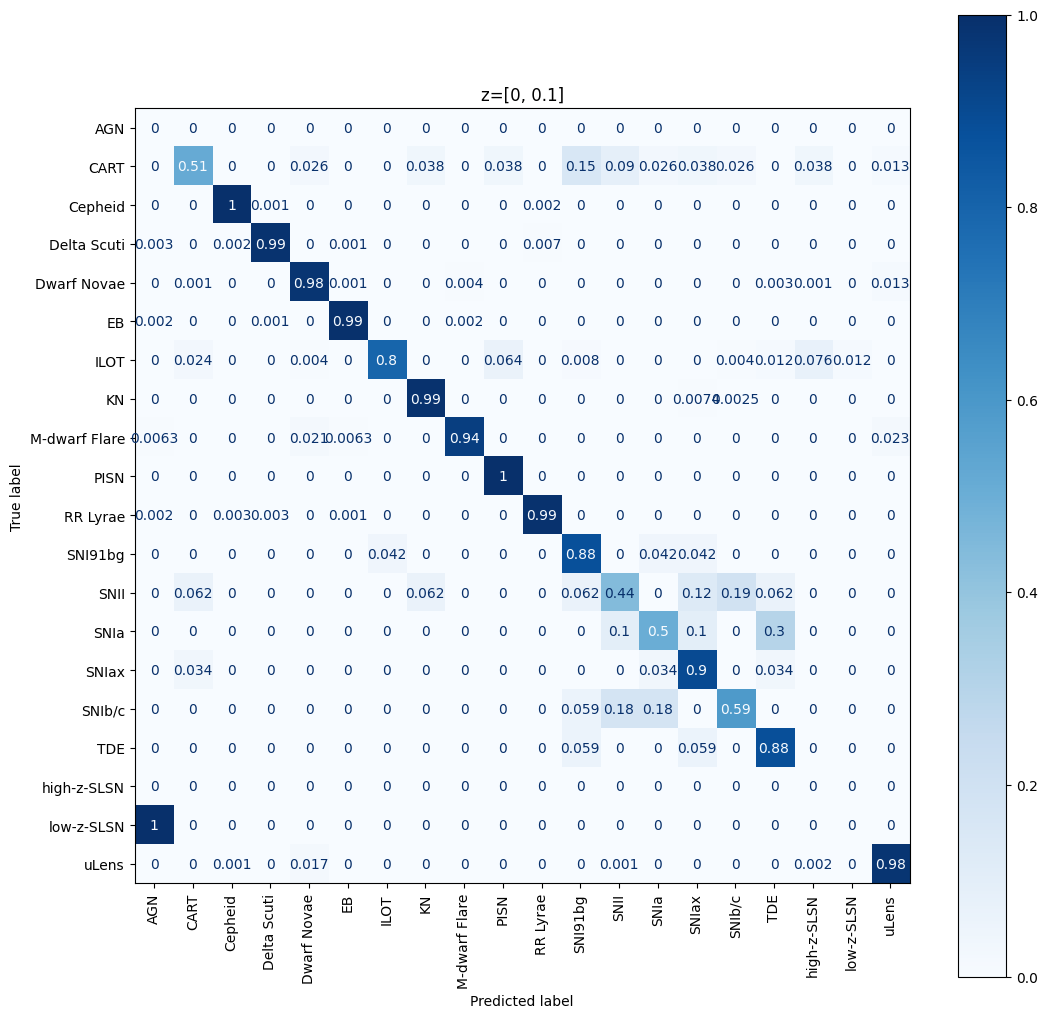

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

              precision    recall  f1-score   support

         AGN       1.00      1.00      1.00         5
        CART       0.92      0.55      0.69       298
 Dwarf Novae       0.00      0.00      0.00         0
        ILOT       0.99      0.89      0.94       542
          KN       0.96      0.97      0.97       507
        PISN       0.35      0.80      0.48        10
     SNI91bg       0.75      0.94      0.83       107
        SNII       0.45      0.55      0.49        86
        SNIa       0.64      0.83      0.72        35
       SNIax       0.55      0.77      0.64       113
      SNIb/c       0.50      0.58      0.54       107
         TDE       0.81      0.89      0.85        87
 high-z-SLSN       0.00      0.00      0.00         0
  low-z-SLSN       0.31      0.57      0.40         7
       uLens       0.00      0.00      0.00         0

    accuracy                           0.82      1904
   macro avg       0.55      0.62      0.57      1904
weighted avg       0.86   

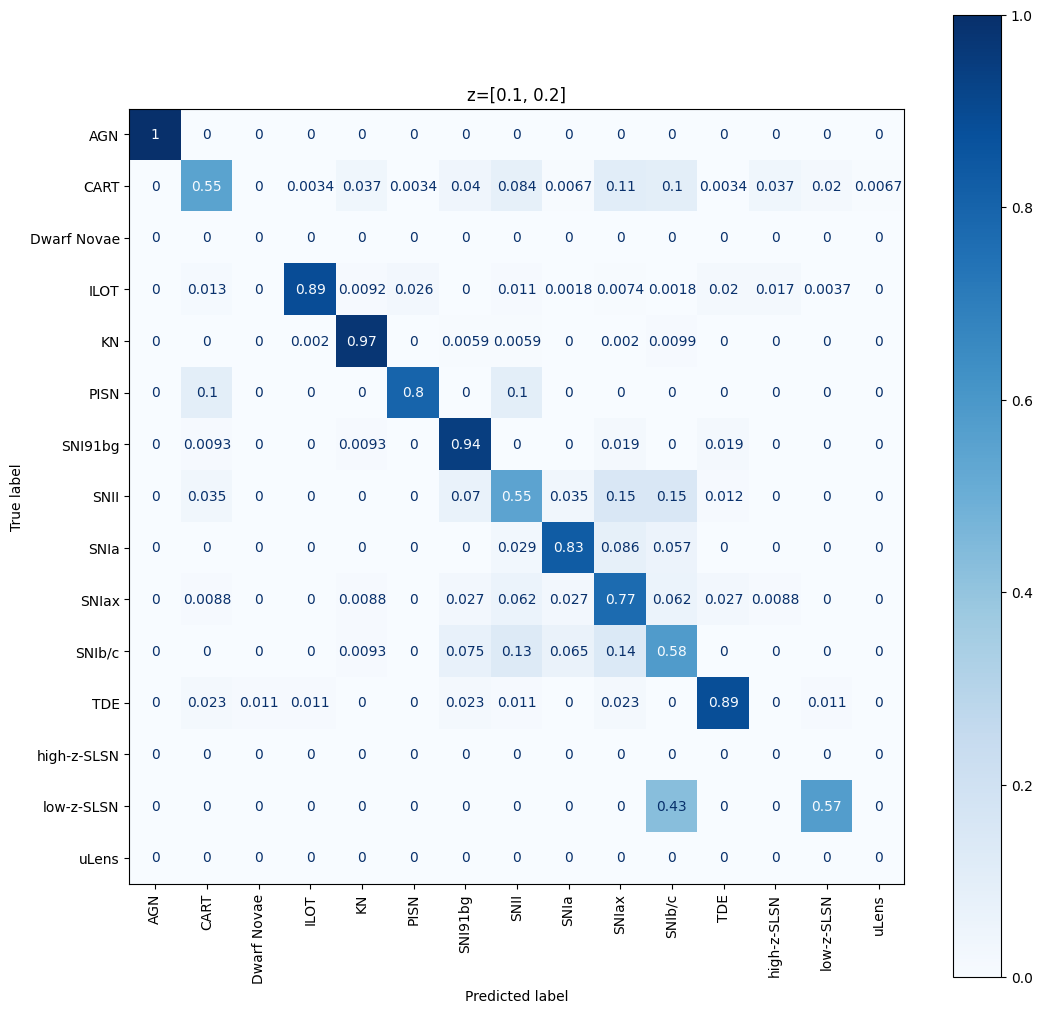

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

              precision    recall  f1-score   support

         AGN       1.00      0.93      0.97        15
        CART       0.87      0.56      0.68       282
 Delta Scuti       0.00      0.00      0.00         0
 Dwarf Novae       0.00      0.00      0.00         0
        ILOT       0.98      0.91      0.95       206
          KN       0.93      0.97      0.95        89
        PISN       0.95      0.86      0.90        21
     SNI91bg       0.91      0.96      0.93       304
        SNII       0.58      0.61      0.60       147
        SNIa       0.73      0.81      0.77        84
       SNIax       0.62      0.73      0.67       222
      SNIb/c       0.53      0.59      0.56       176
         TDE       0.87      0.94      0.90       131
 high-z-SLSN       0.00      0.00      0.00         0
  low-z-SLSN       0.91      0.80      0.85        25
       uLens       0.00      0.00      0.00         0

    accuracy                           0.78      1702
   macro avg       0.62   

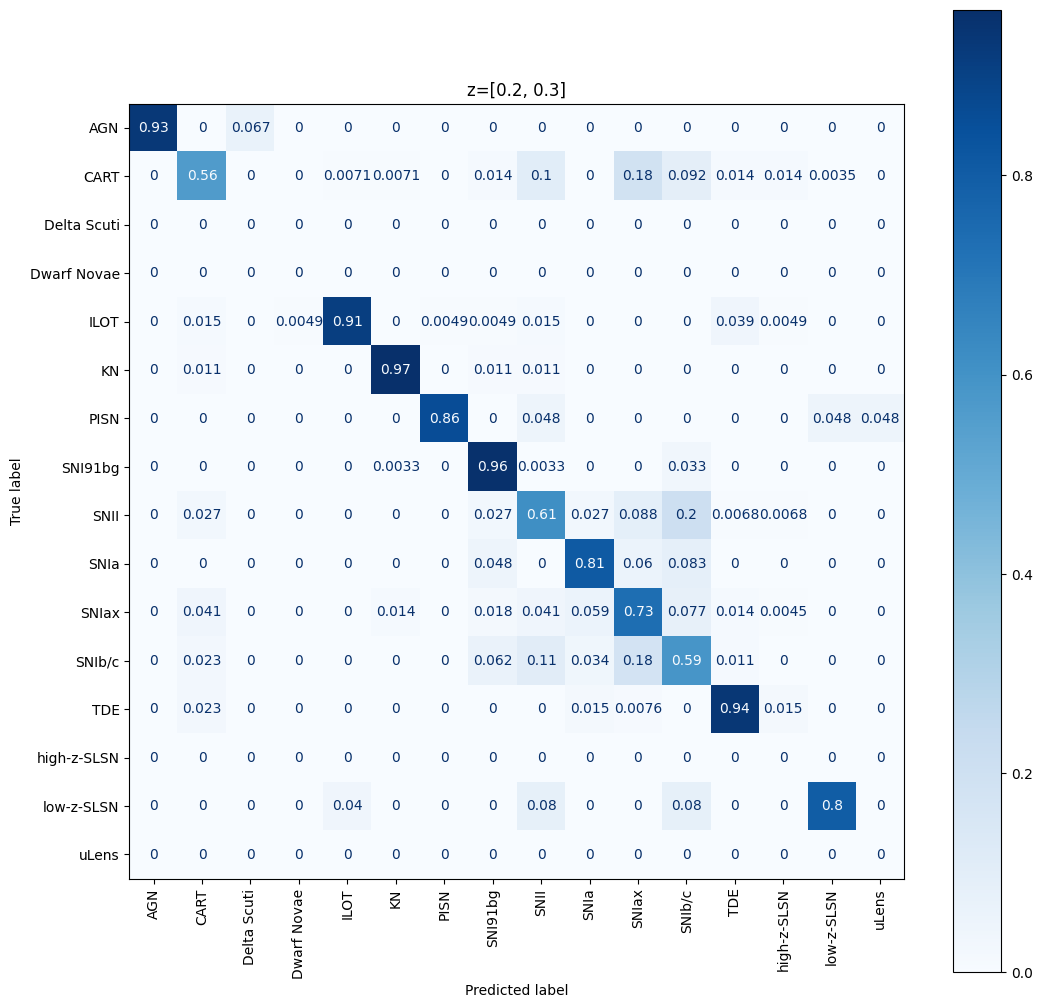

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

              precision    recall  f1-score   support

         AGN       0.94      1.00      0.97        15
        CART       0.85      0.51      0.63       221
        ILOT       0.29      1.00      0.44         2
          KN       0.00      0.00      0.00         0
        PISN       1.00      0.89      0.94        35
     SNI91bg       0.93      0.94      0.93       358
        SNII       0.61      0.60      0.61       158
        SNIa       0.69      0.84      0.76       105
       SNIax       0.65      0.74      0.69       209
      SNIb/c       0.58      0.65      0.62       190
         TDE       0.93      0.95      0.94       143
 high-z-SLSN       0.00      0.00      0.00         0
  low-z-SLSN       0.94      0.92      0.93        52
       uLens       0.00      0.00      0.00         0

    accuracy                           0.77      1488
   macro avg       0.60      0.65      0.60      1488
weighted avg       0.78      0.77      0.77      1488



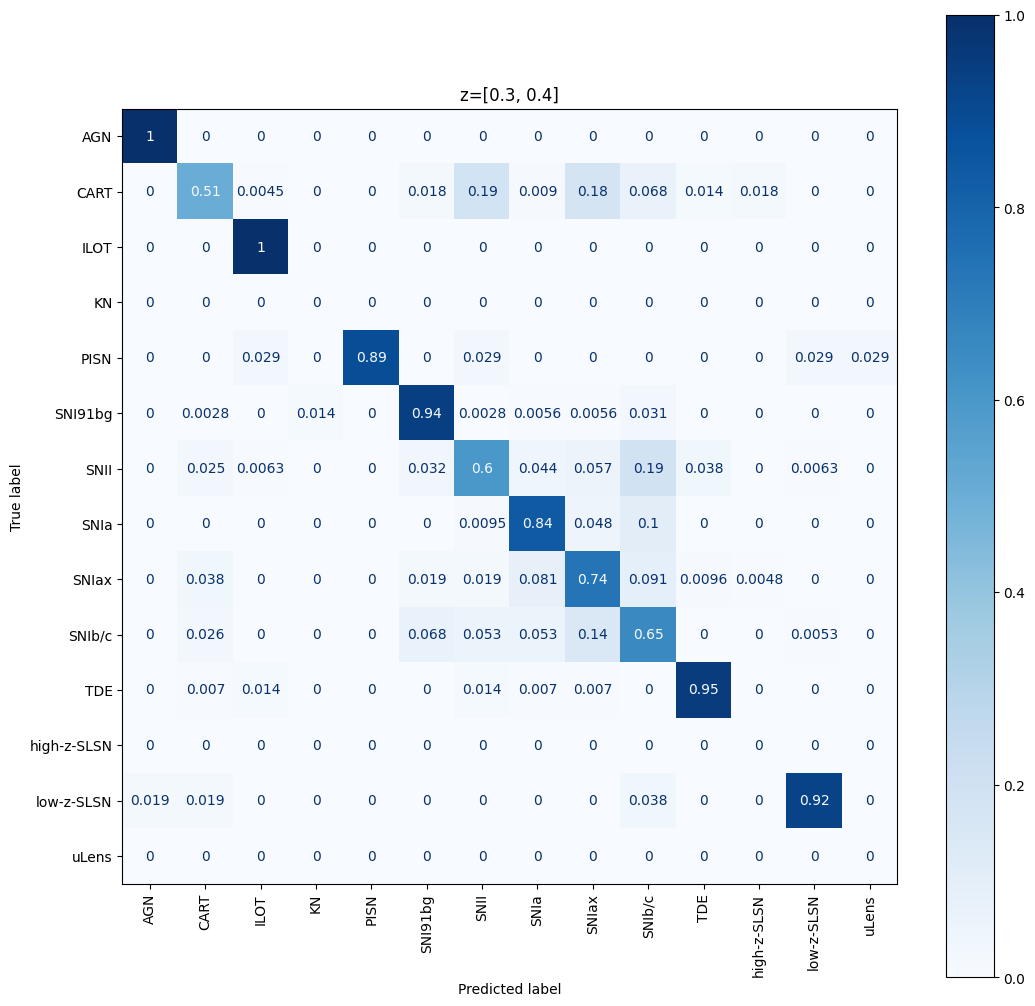

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

              precision    recall  f1-score   support

         AGN       1.00      0.99      0.99        81
        CART       0.30      0.35      0.32        23
 Delta Scuti       0.00      0.00      0.00         0
 Dwarf Novae       0.00      0.00      0.00         0
          EB       0.00      0.00      0.00         0
        ILOT       0.00      0.00      0.00         0
        PISN       0.98      0.91      0.94       184
     SNI91bg       0.59      0.85      0.70        34
        SNII       0.77      0.68      0.73       219
        SNIa       0.82      0.83      0.83       361
       SNIax       0.68      0.76      0.72       208
      SNIb/c       0.72      0.66      0.69       198
         TDE       0.96      0.95      0.96       217
 high-z-SLSN       0.00      0.00      0.00         0
  low-z-SLSN       0.95      0.88      0.92       265

    accuracy                           0.82      1790
   macro avg       0.52      0.52      0.52      1790
weighted avg       0.84   

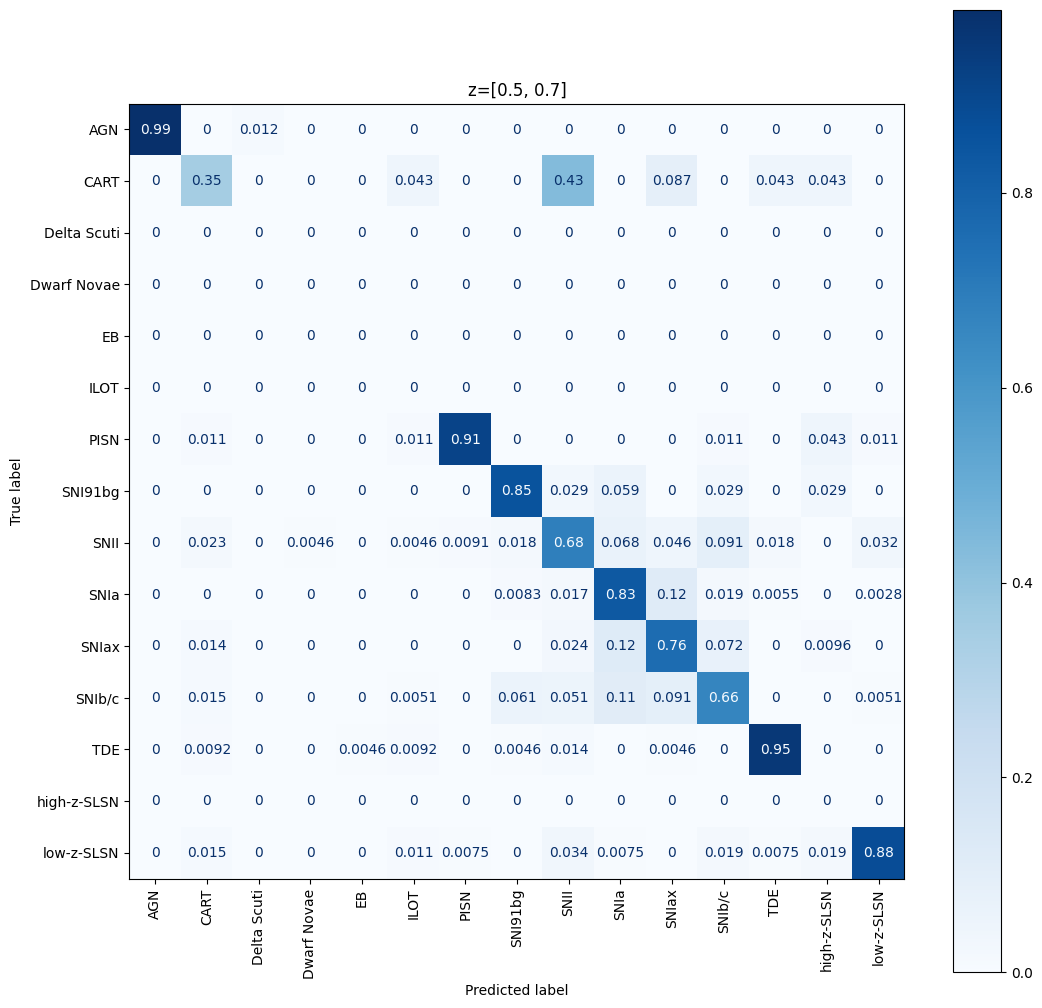

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

               precision    recall  f1-score   support

          AGN       0.99      0.99      0.99       143
         CART       0.08      1.00      0.14         1
  Delta Scuti       0.00      0.00      0.00         0
         ILOT       0.00      0.00      0.00         0
M-dwarf Flare       0.00      0.00      0.00         0
         PISN       0.98      0.95      0.96       369
      SNI91bg       0.00      0.00      0.00         0
         SNII       0.75      0.65      0.70       130
         SNIa       0.83      0.81      0.82       243
        SNIax       0.43      0.64      0.51        28
       SNIb/c       0.70      0.62      0.66       114
          TDE       0.97      0.97      0.97       181
  high-z-SLSN       0.00      0.00      0.00         0
   low-z-SLSN       0.97      0.83      0.90       580

     accuracy                           0.85      1789
    macro avg       0.48      0.53      0.48      1789
 weighted avg       0.91      0.85      0.88      1789



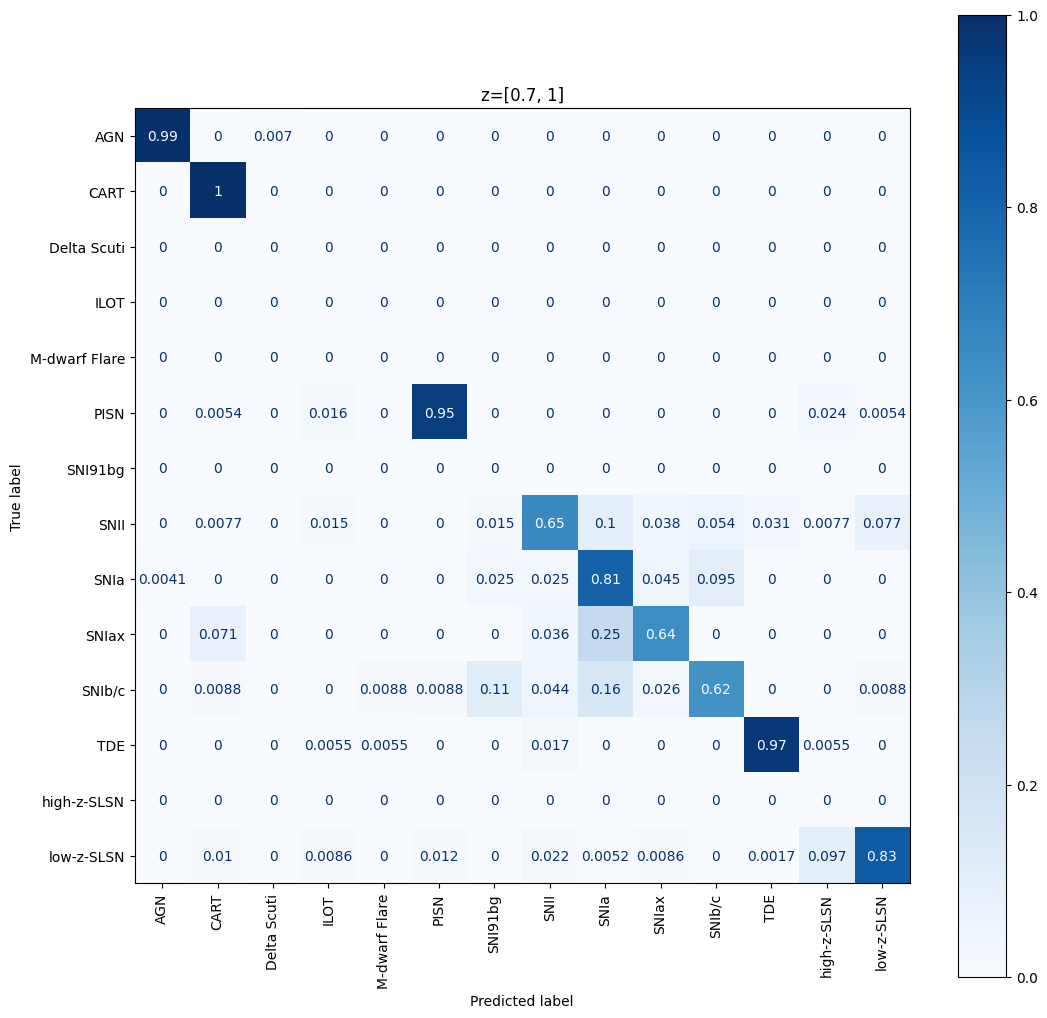

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

              precision    recall  f1-score   support

         AGN       0.99      1.00      0.99       242
        CART       0.00      0.00      0.00         0
 Delta Scuti       0.00      0.00      0.00         0
        ILOT       0.00      0.00      0.00         0
        PISN       0.99      0.93      0.96       307
     SNI91bg       0.00      0.00      0.00         0
        SNII       0.83      0.69      0.75        75
        SNIa       0.53      0.53      0.53        19
       SNIax       0.00      0.00      0.00         0
      SNIb/c       0.92      0.57      0.71        21
         TDE       0.98      0.95      0.97        65
 high-z-SLSN       0.93      0.84      0.89       402
  low-z-SLSN       0.00      0.00      0.00         0

    accuracy                           0.89      1131
   macro avg       0.47      0.42      0.45      1131
weighted avg       0.95      0.89      0.92      1131



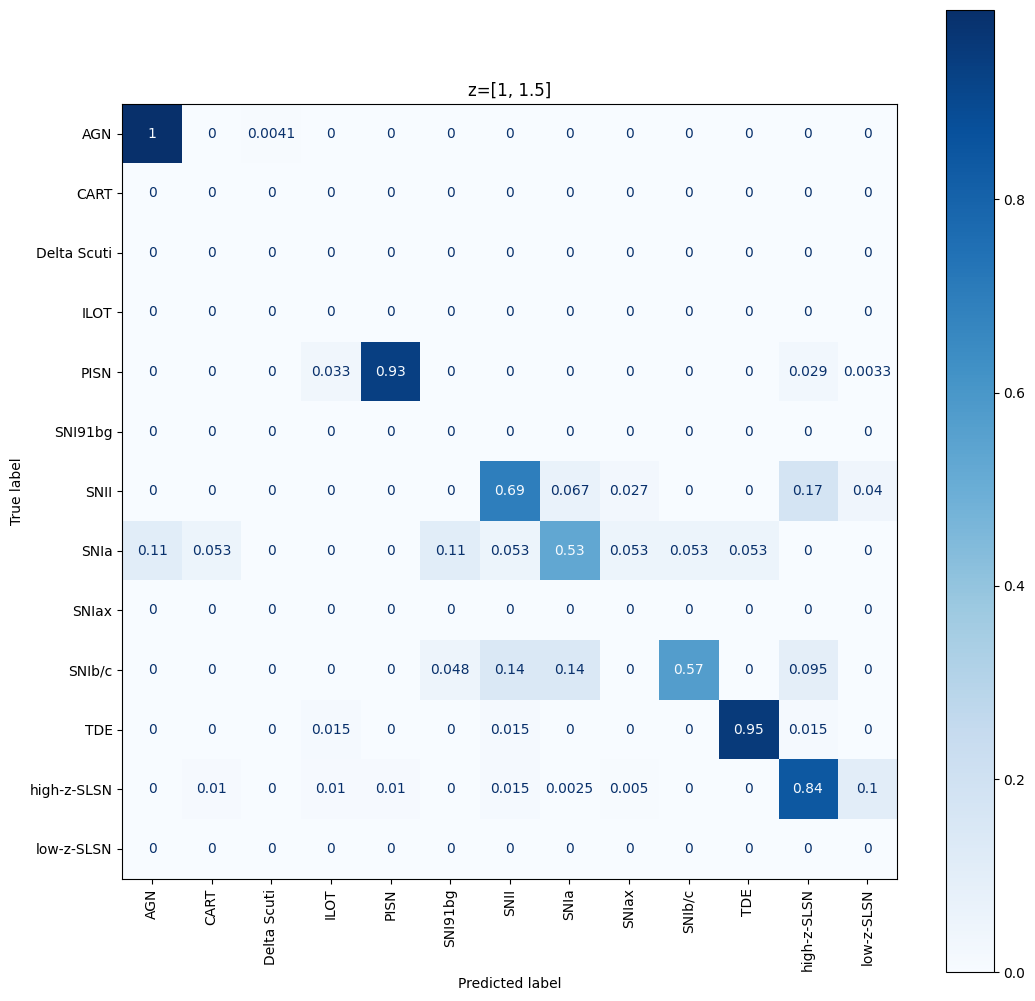

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

              precision    recall  f1-score   support

         AGN       1.00      0.99      1.00       207
        CART       0.00      0.00      0.00         0
 Dwarf Novae       0.00      0.00      0.00         0
          EB       0.00      0.00      0.00         0
        ILOT       0.00      0.00      0.00         0
          KN       0.00      0.00      0.00         0
        PISN       0.62      1.00      0.77        10
        SNII       0.92      0.67      0.77        18
         TDE       0.71      1.00      0.83        10
 high-z-SLSN       0.99      0.92      0.95       308
  low-z-SLSN       0.00      0.00      0.00         0

    accuracy                           0.94       553
   macro avg       0.39      0.42      0.39       553
weighted avg       0.98      0.94      0.96       553



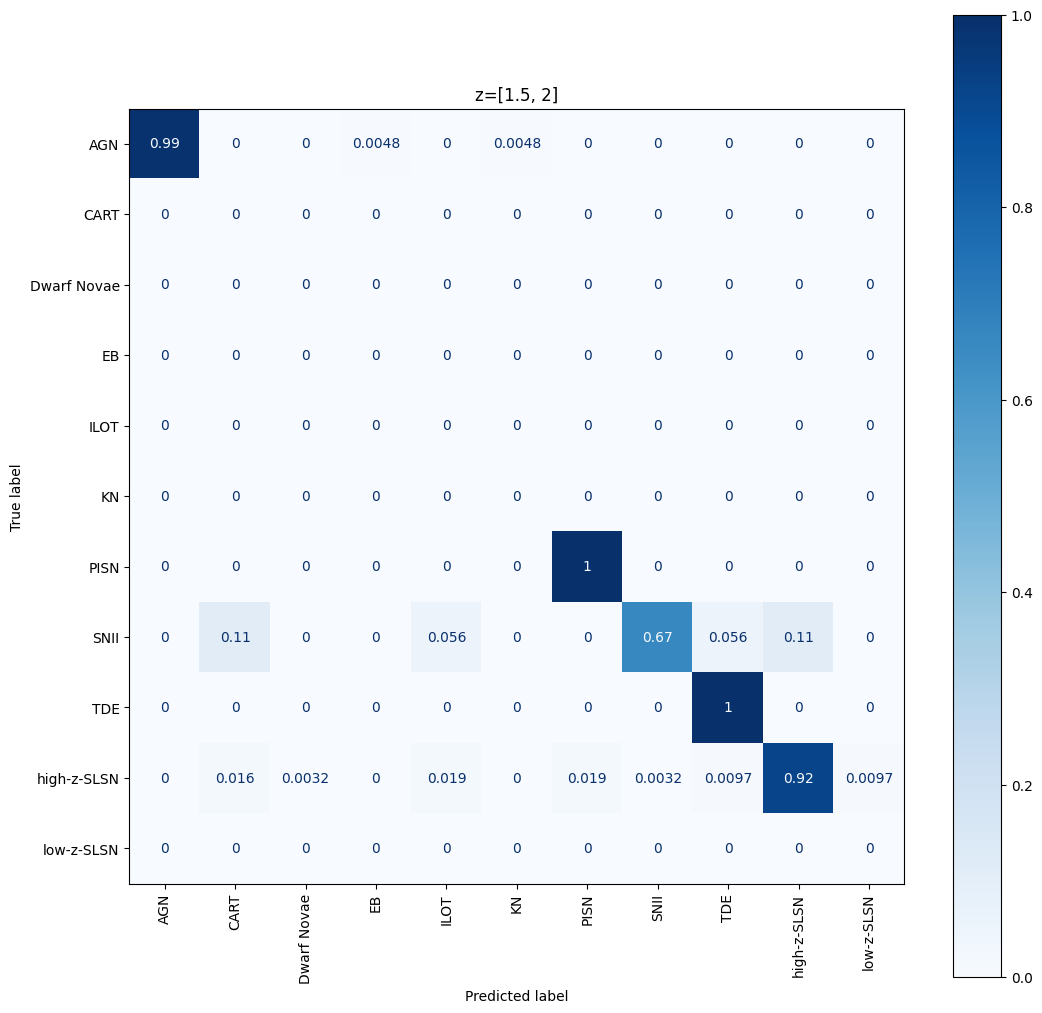

              precision    recall  f1-score   support

         AGN       1.00      1.00      1.00       164
        CART       0.00      0.00      0.00         0
 Dwarf Novae       0.00      0.00      0.00         0
        ILOT       0.00      0.00      0.00         0
        PISN       0.00      0.00      0.00         0
 high-z-SLSN       1.00      0.95      0.97       171
       uLens       0.00      0.00      0.00         0

    accuracy                           0.97       335
   macro avg       0.29      0.28      0.28       335
weighted avg       1.00      0.97      0.99       335



/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

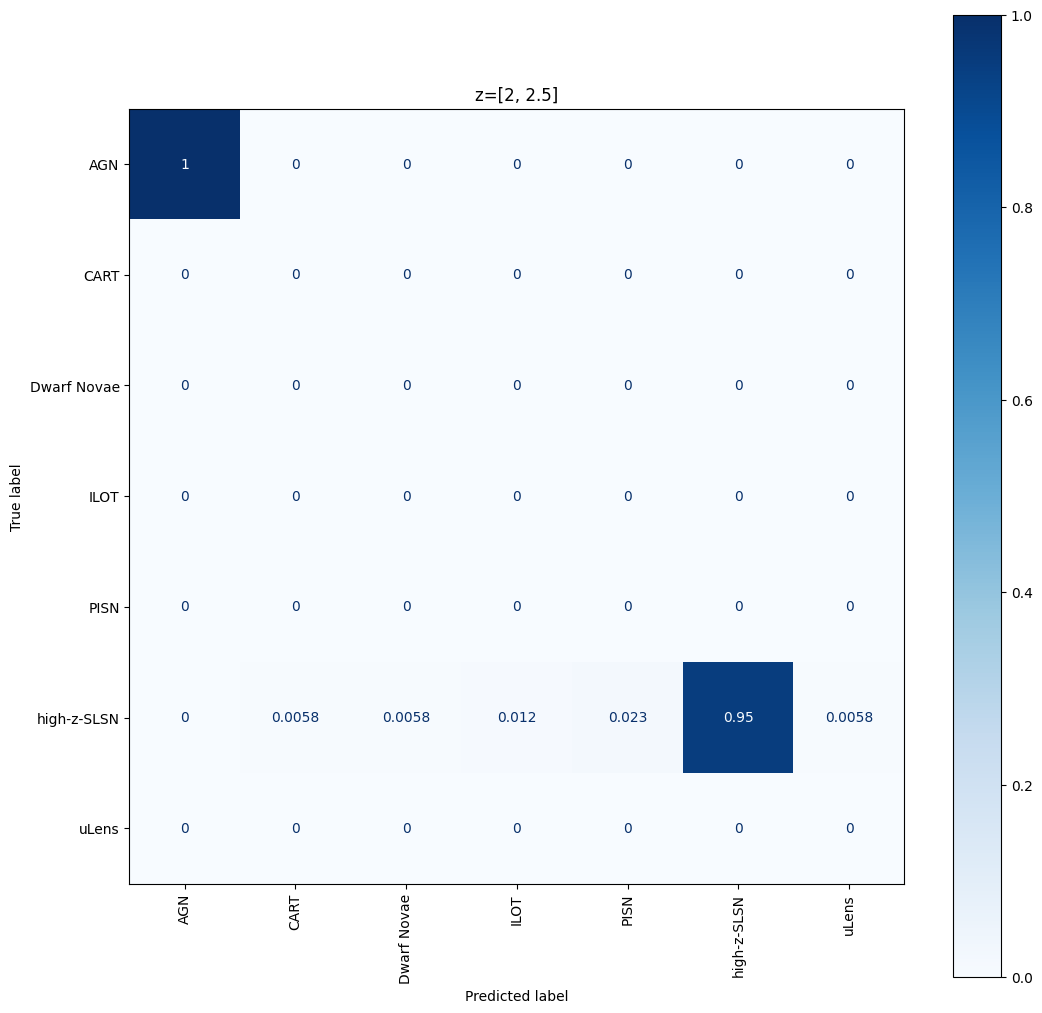

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

              precision    recall  f1-score   support

         AGN       1.00      1.00      1.00       103
        CART       0.00      0.00      0.00         0
        ILOT       0.00      0.00      0.00         0
 high-z-SLSN       1.00      0.97      0.98        67

    accuracy                           0.99       170
   macro avg       0.50      0.49      0.50       170
weighted avg       1.00      0.99      0.99       170



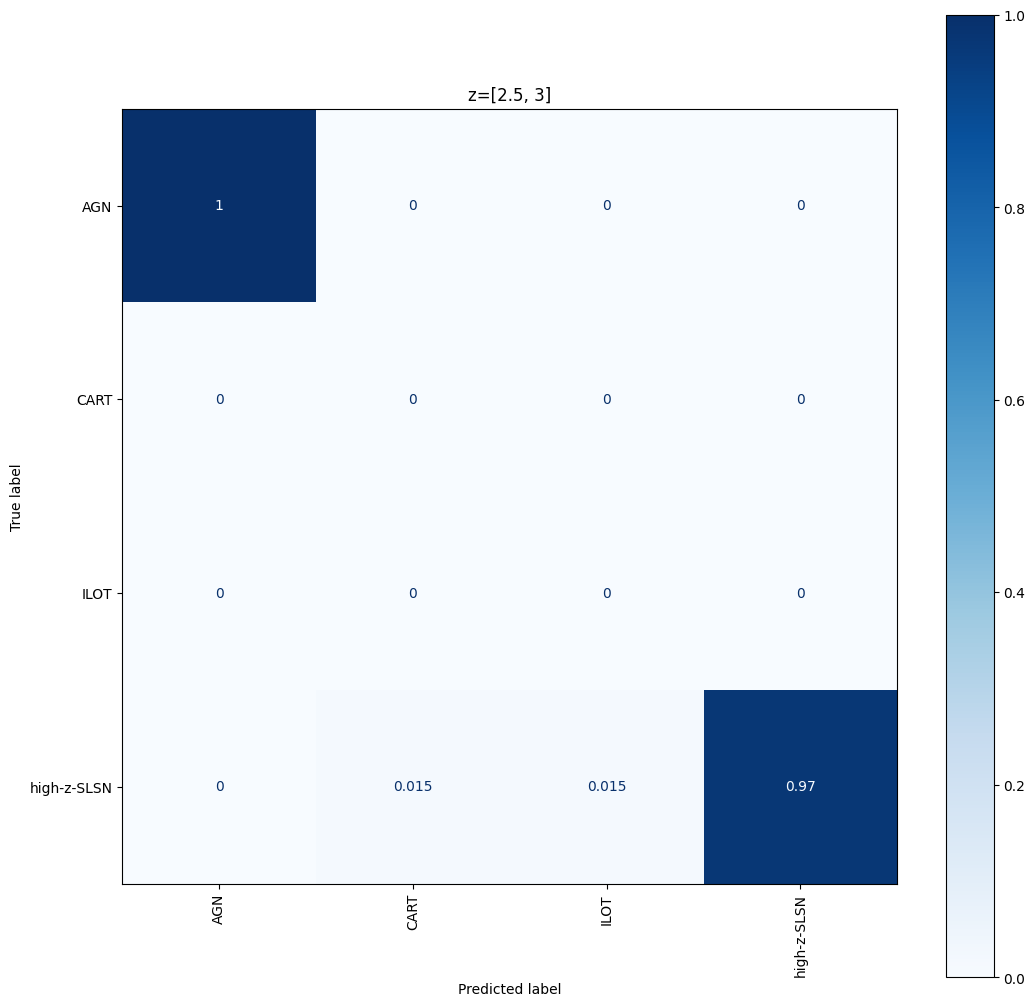

In [18]:
z_range = [[0,0.1], [0.1,0.2],[0.2, 0.3], [0.3, 0.4], [0.5, 0.7], [0.7, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3]]

precision = []
recall = []
macro_f1 = []

file_names = []

for r in z_range:

    df_in_range = all_classification.filter((all_classification['SIM_REDSHIFT_CMB']>=r[0]) & (all_classification['SIM_REDSHIFT_CMB']<r[1]))

    labels = np.unique(df_in_range['true'].to_numpy().tolist() + df_in_range['pred'].to_numpy().tolist()) 

    report = classification_report(df_in_range['true'], df_in_range['pred'], output_dict=True)
    precision.append(report['high-z-SLSN']['precision'])
    recall.append(report['high-z-SLSN']['recall'])
    macro_f1.append(report['macro avg']['f1-score'])

    report = classification_report(df_in_range['true'], df_in_range['pred'], output_dict=False)
    print(report)

    cm = confusion_matrix(df_in_range['true'], df_in_range['pred'], normalize='true', labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(12.5,12.5))
    disp.plot(ax=ax, cmap='Blues')

    plt.xticks(rotation=90)
    plt.title(f"z={r}")
    fname = f'z{r[0]}.png'
    file_names.append(fname)

    plt.savefig(fname)
    plt.show()


/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                 precision    recall  f1-score   support

Not high-z-SLSN       1.00      1.00      1.00      7643
    high-z-SLSN       0.00      0.00      0.00         0

       accuracy                           1.00      7643
      macro avg       0.50      0.50      0.50      7643
   weighted avg       1.00      1.00      1.00      7643



/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


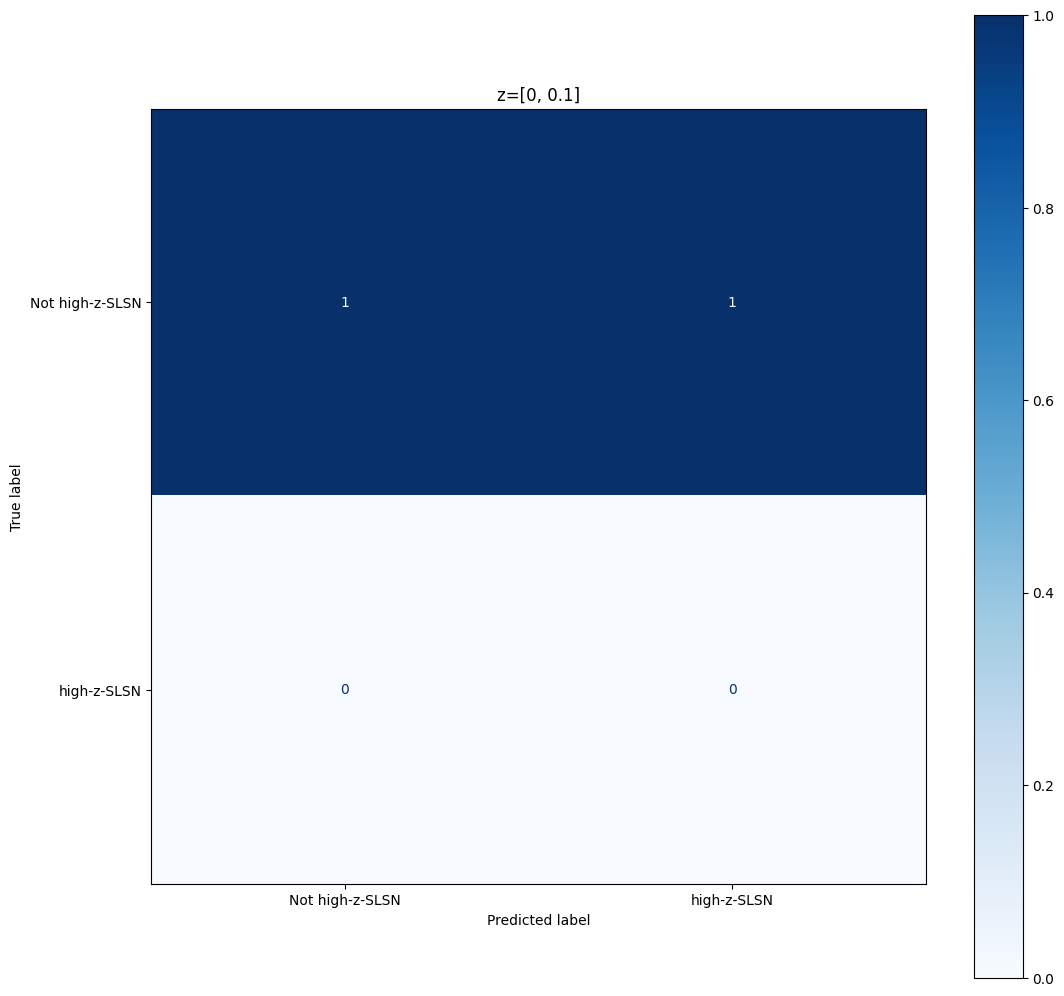

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

                 precision    recall  f1-score   support

Not high-z-SLSN       1.00      0.99      0.99      1904
    high-z-SLSN       0.00      0.00      0.00         0

       accuracy                           0.99      1904
      macro avg       0.50      0.49      0.50      1904
   weighted avg       1.00      0.99      0.99      1904



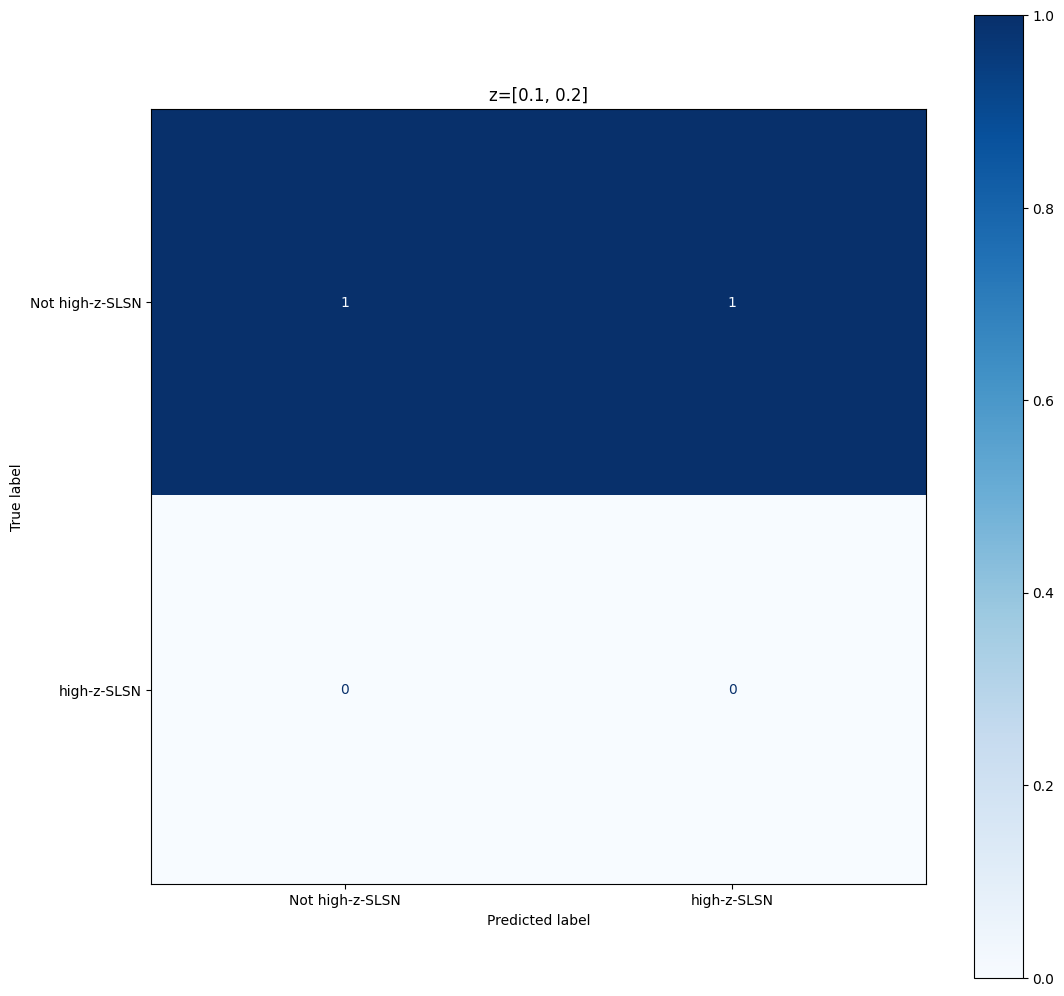

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

                 precision    recall  f1-score   support

Not high-z-SLSN       1.00      0.99      1.00      1702
    high-z-SLSN       0.00      0.00      0.00         0

       accuracy                           0.99      1702
      macro avg       0.50      0.50      0.50      1702
   weighted avg       1.00      0.99      1.00      1702



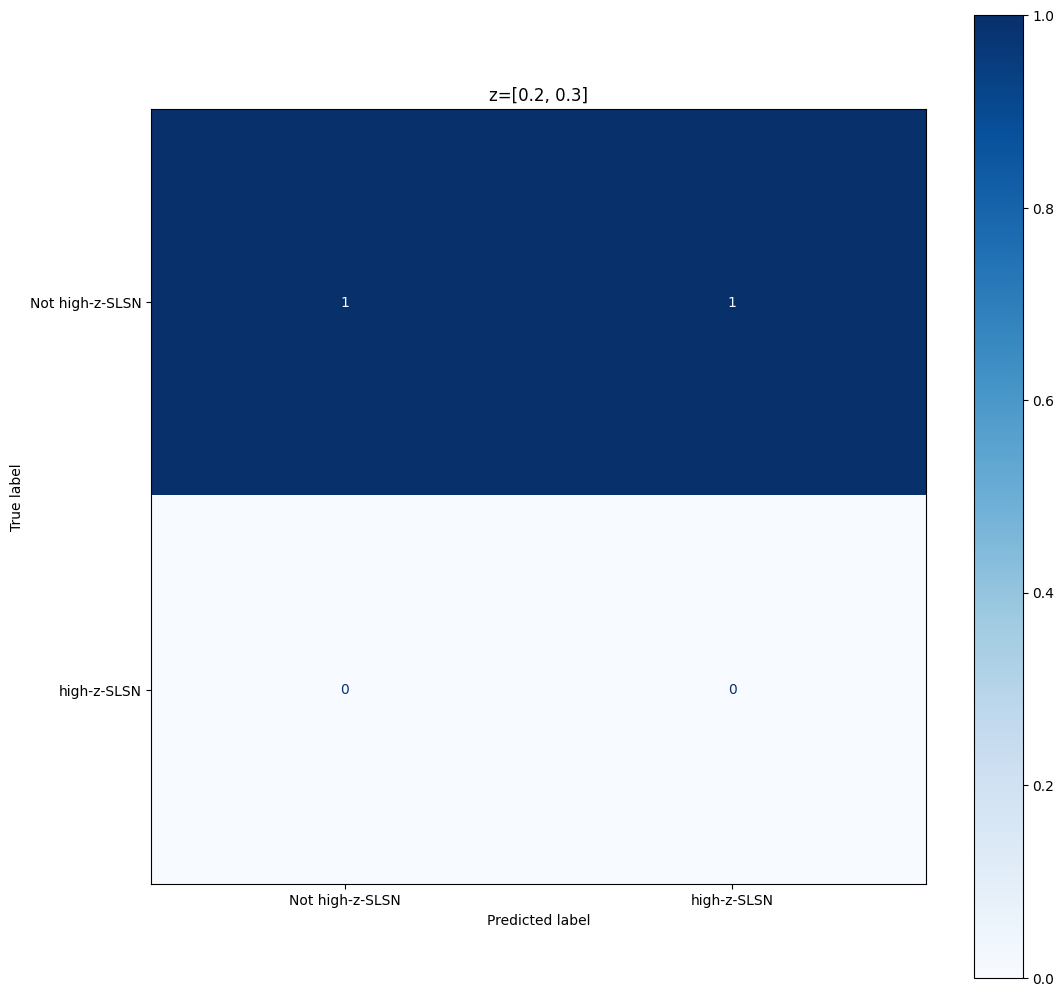

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

                 precision    recall  f1-score   support

Not high-z-SLSN       1.00      1.00      1.00      1488
    high-z-SLSN       0.00      0.00      0.00         0

       accuracy                           1.00      1488
      macro avg       0.50      0.50      0.50      1488
   weighted avg       1.00      1.00      1.00      1488



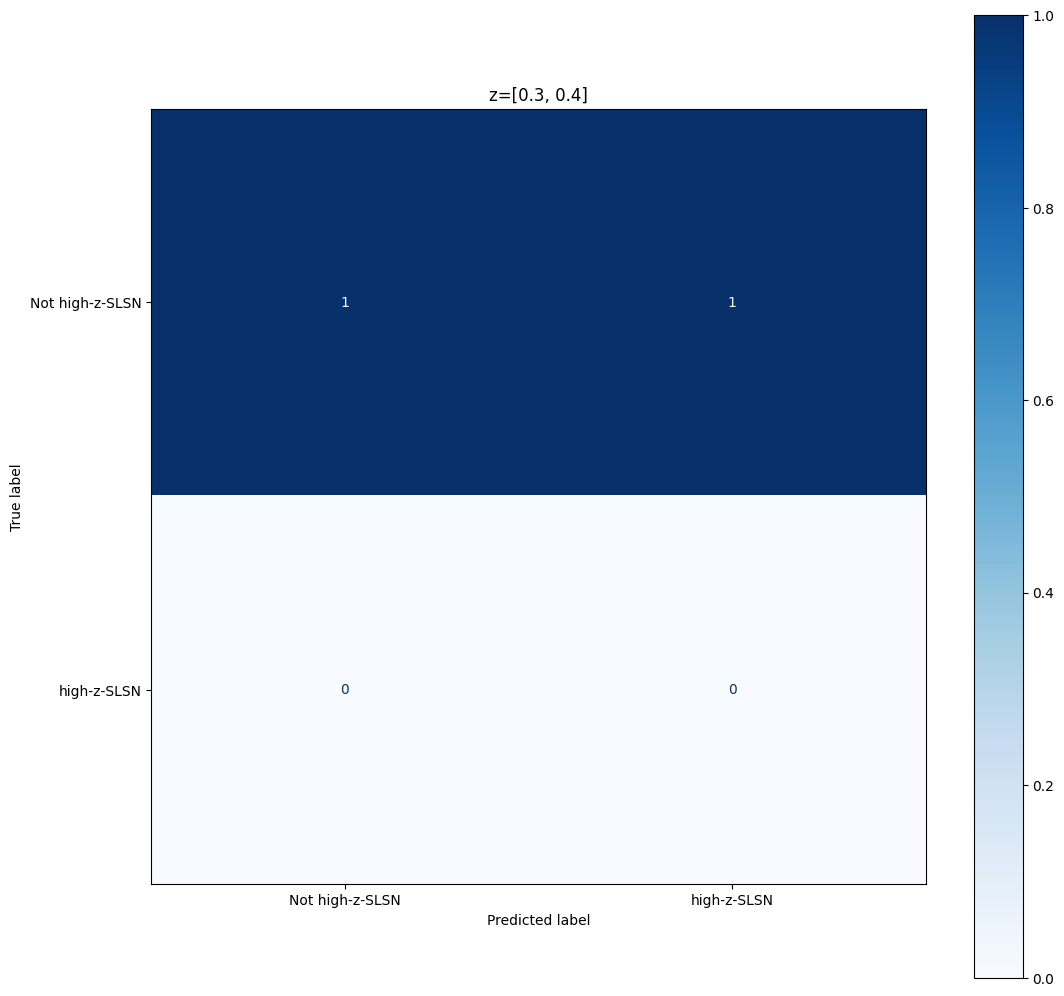

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

                 precision    recall  f1-score   support

Not high-z-SLSN       1.00      0.99      1.00      1790
    high-z-SLSN       0.00      0.00      0.00         0

       accuracy                           0.99      1790
      macro avg       0.50      0.50      0.50      1790
   weighted avg       1.00      0.99      1.00      1790



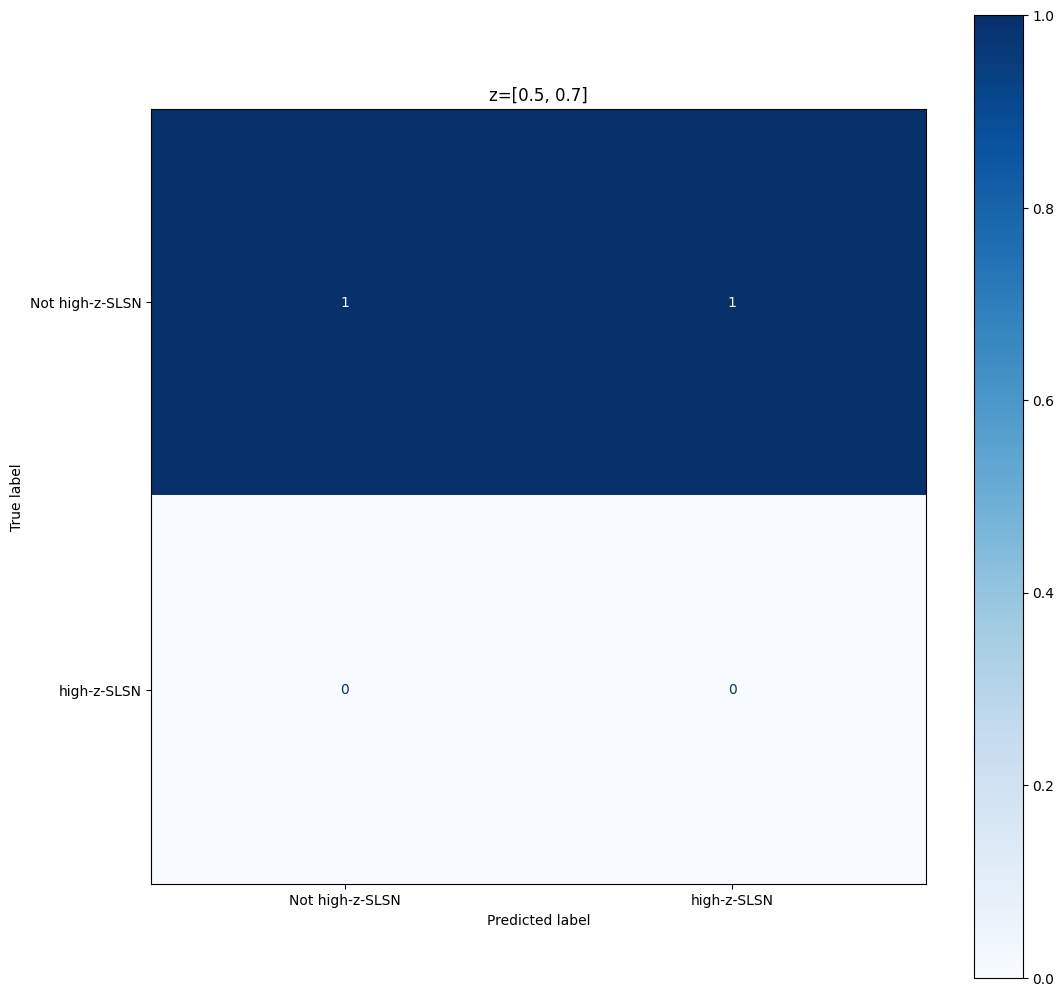

/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vedshah/anaconda3/envs/VT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

                 precision    recall  f1-score   support

Not high-z-SLSN       1.00      0.96      0.98      1789
    high-z-SLSN       0.00      0.00      0.00         0

       accuracy                           0.96      1789
      macro avg       0.50      0.48      0.49      1789
   weighted avg       1.00      0.96      0.98      1789



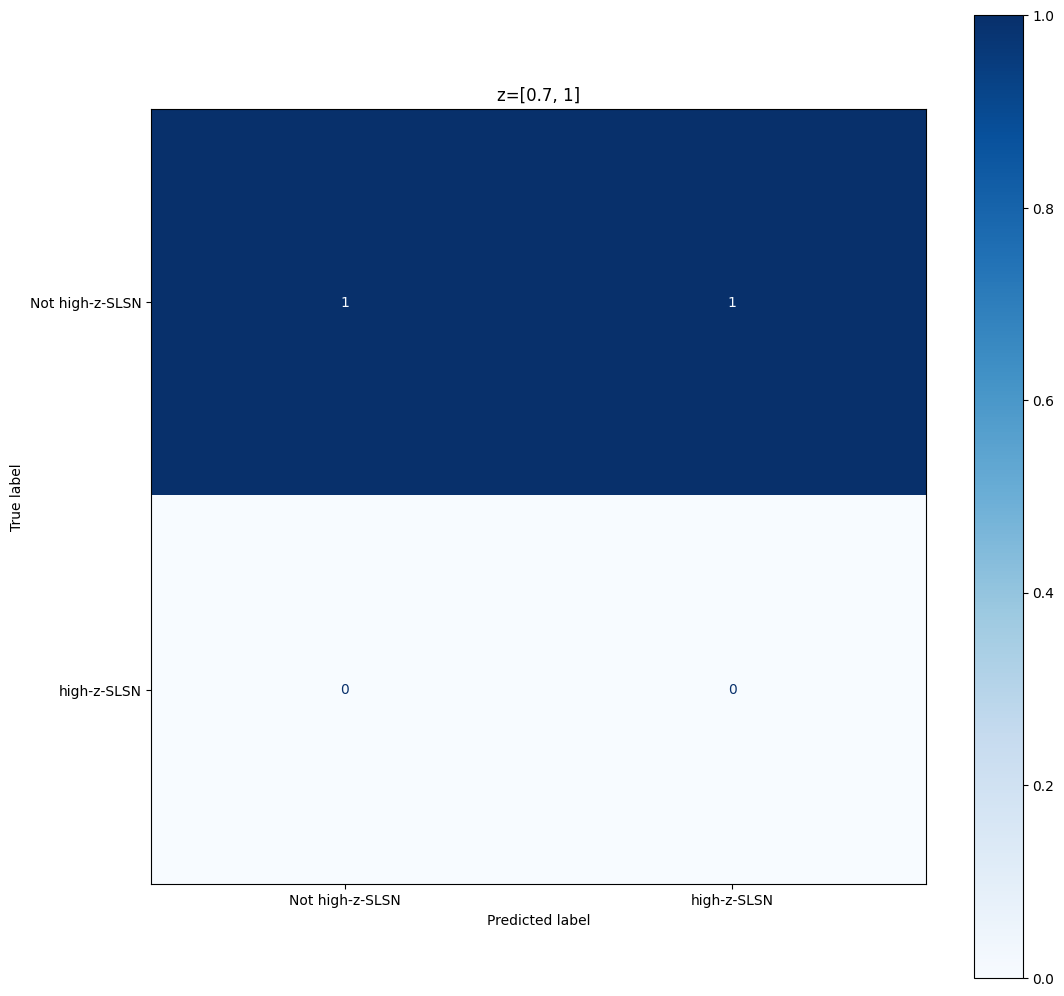

                 precision    recall  f1-score   support

Not high-z-SLSN       0.92      0.97      0.94       729
    high-z-SLSN       0.93      0.84      0.89       402

       accuracy                           0.92      1131
      macro avg       0.92      0.90      0.91      1131
   weighted avg       0.92      0.92      0.92      1131



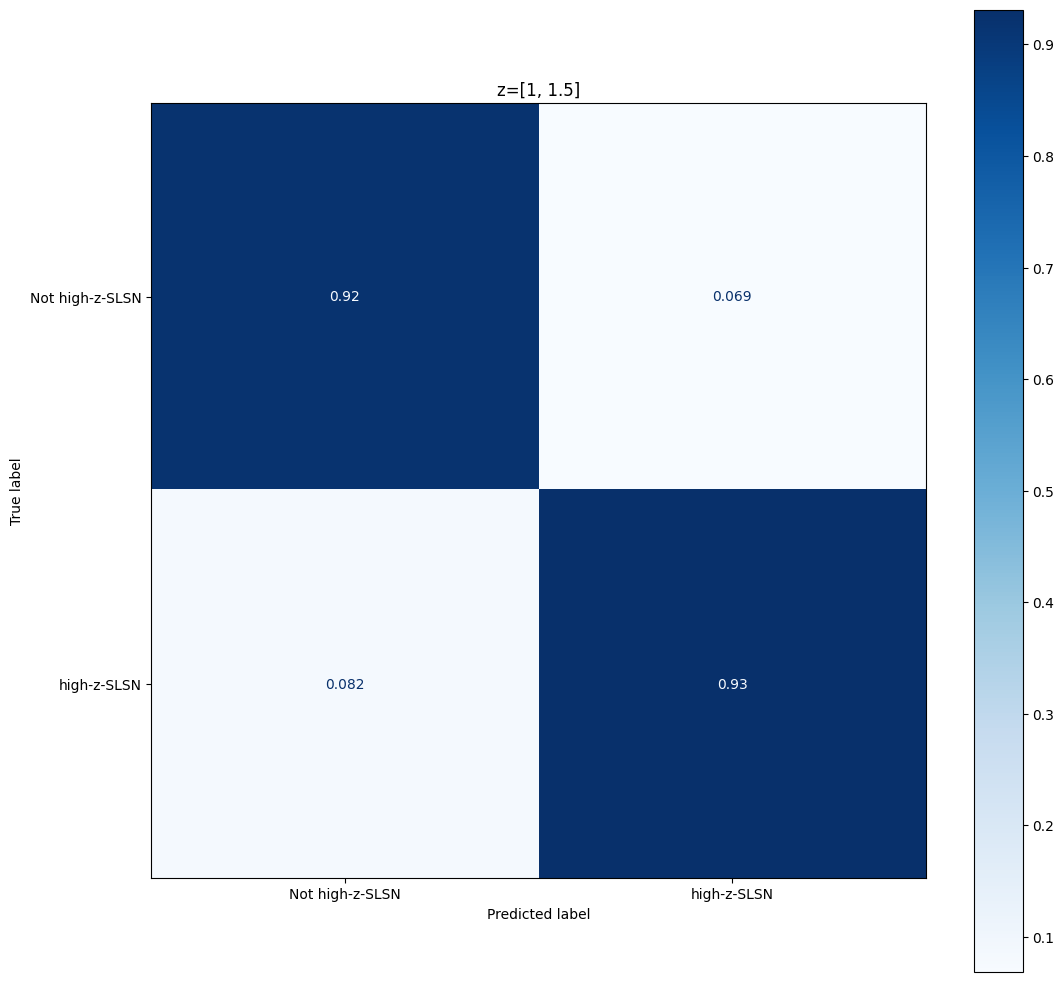

                 precision    recall  f1-score   support

Not high-z-SLSN       0.91      0.99      0.95       245
    high-z-SLSN       0.99      0.92      0.95       308

       accuracy                           0.95       553
      macro avg       0.95      0.96      0.95       553
   weighted avg       0.95      0.95      0.95       553



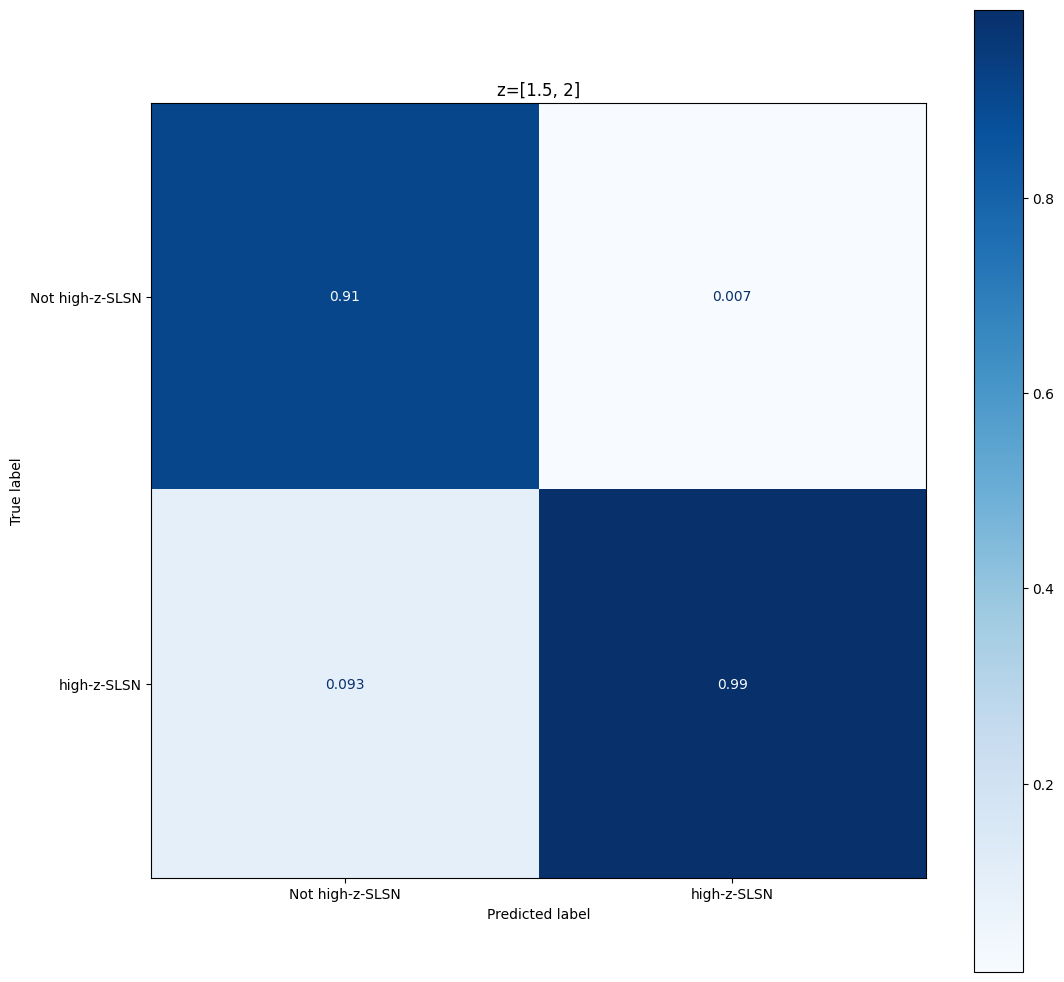

                 precision    recall  f1-score   support

Not high-z-SLSN       0.95      1.00      0.97       164
    high-z-SLSN       1.00      0.95      0.97       171

       accuracy                           0.97       335
      macro avg       0.97      0.97      0.97       335
   weighted avg       0.97      0.97      0.97       335



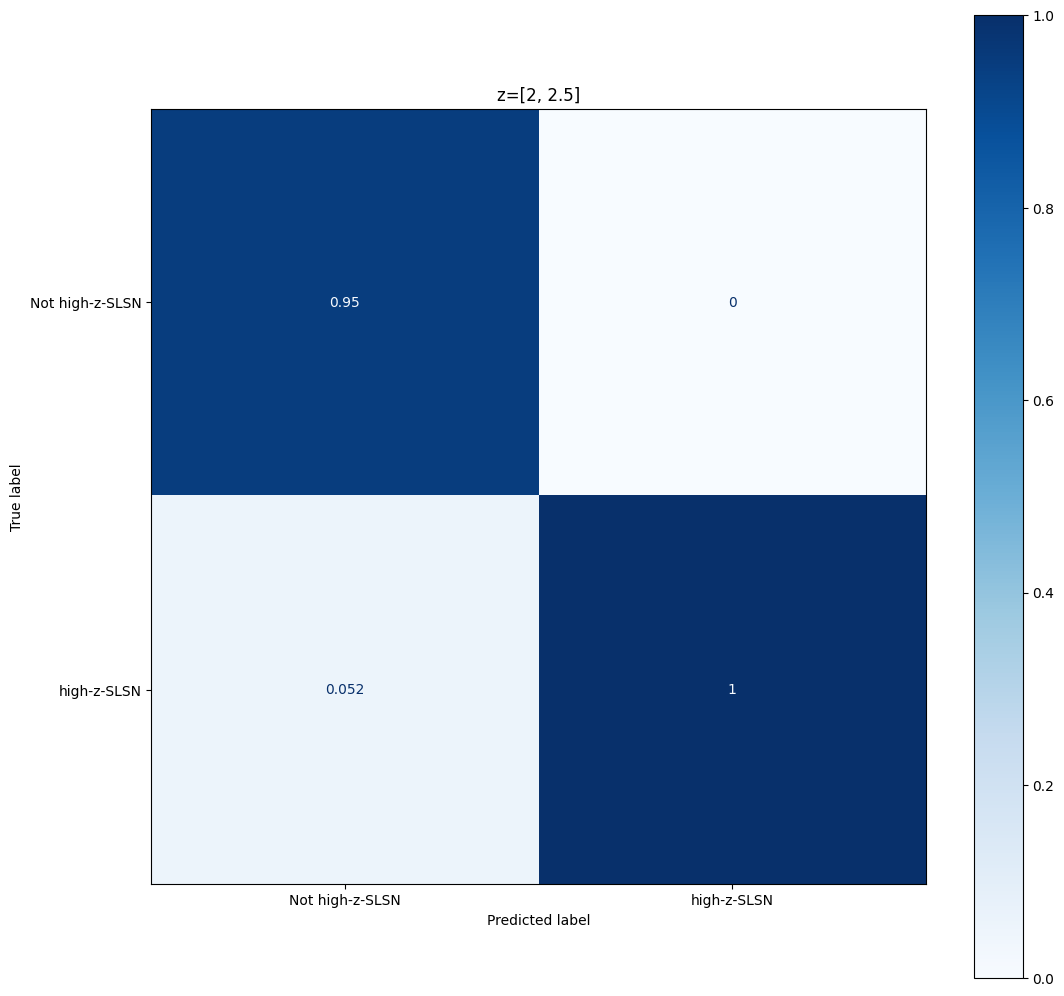

                 precision    recall  f1-score   support

Not high-z-SLSN       0.98      1.00      0.99       103
    high-z-SLSN       1.00      0.97      0.98        67

       accuracy                           0.99       170
      macro avg       0.99      0.99      0.99       170
   weighted avg       0.99      0.99      0.99       170



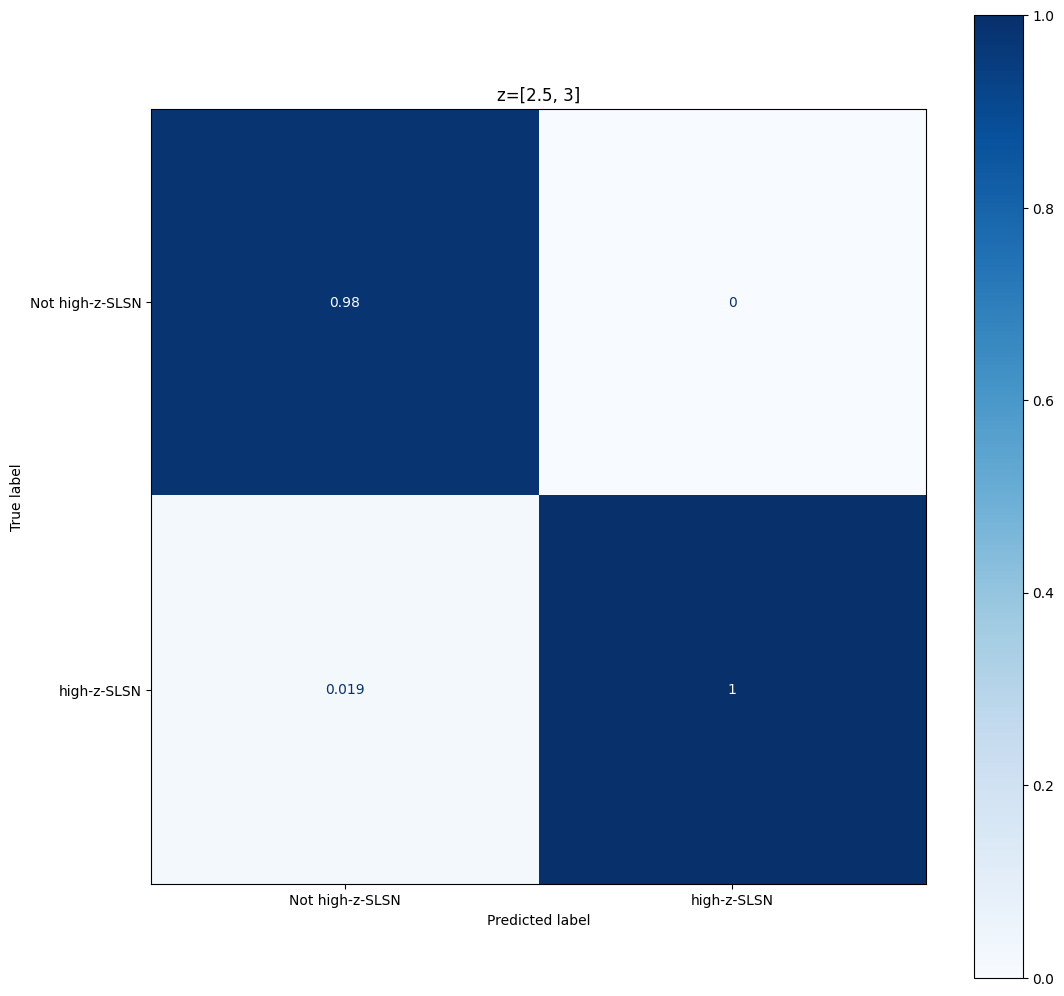

                 precision    recall  f1-score   support

Not high-z-SLSN       0.99      0.99      0.99     18796
    high-z-SLSN       0.84      0.90      0.87      1000

       accuracy                           0.99     19796
      macro avg       0.92      0.95      0.93     19796
   weighted avg       0.99      0.99      0.99     19796



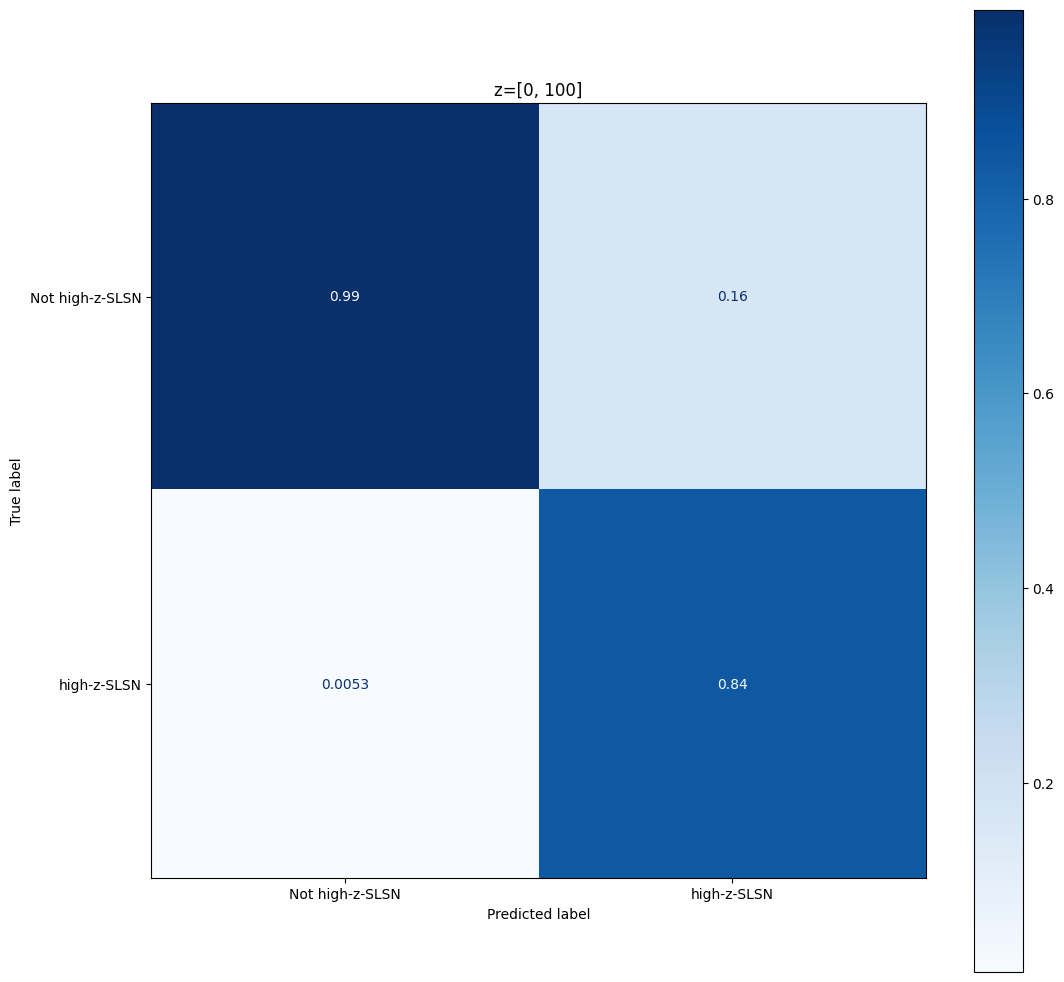

In [19]:
z_range = [[0,0.1], [0.1,0.2],[0.2, 0.3], [0.3, 0.4], [0.5, 0.7], [0.7, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [0, 100]]

precision = []
recall = []
macro_f1 = []

sl_file_names = []

for r in z_range:

    df_in_range = all_classification.filter((all_classification['SIM_REDSHIFT_CMB']>=r[0]) & (all_classification['SIM_REDSHIFT_CMB']<r[1]))

    df_in_range = df_in_range.with_columns([
        pl.when(pl.col("true") == "high-z-SLSN")
        .then(pl.lit("high-z-SLSN"))
        .otherwise(pl.lit("Not high-z-SLSN"))
        .alias("SLSN_true"),

        pl.when(pl.col("pred") == "high-z-SLSN")
        .then(pl.lit("high-z-SLSN"))
        .otherwise(pl.lit("Not high-z-SLSN"))
        .alias("SLSN_pred")
    ])    
    labels = np.unique(df_in_range['SLSN_true'].to_numpy().tolist() + df_in_range['SLSN_pred'].to_numpy().tolist()) 


    report = classification_report(df_in_range['SLSN_true'], df_in_range['SLSN_pred'], output_dict=True)
    precision.append(report['high-z-SLSN']['precision'])
    recall.append(report['high-z-SLSN']['recall'])
    macro_f1.append(report['macro avg']['f1-score'])

    report = classification_report(df_in_range['SLSN_true'], df_in_range['SLSN_pred'], output_dict=False)
    print(report)

    cm = confusion_matrix(df_in_range['SLSN_true'], df_in_range['SLSN_pred'], normalize='pred', labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(12.5,12.5))
    disp.plot(ax=ax, cmap='Blues')

    #plt.xticks(rotation=90)
    plt.title(f"z={r}")
    fname = f'z_sl{r[0]}.png'
    sl_file_names.append(fname)

    plt.savefig(fname)
    plt.show()


In [20]:
from PIL import Image

# Open images
frames = [Image.open(img) for img in file_names]

# Save as GIF
frames[0].save(
    "z.gif",
    save_all=True,
    append_images=frames[1:],
    duration=900,   # time between frames in ms
    loop=0          # 0 means infinite loop
)

In [21]:
from PIL import Image

# Open images
frames = [Image.open(img) for img in sl_file_names]

# Save as GIF
frames[0].save(
    "z_sl.gif",
    save_all=True,
    append_images=frames[1:],
    duration=900,   # time between frames in ms
    loop=0          # 0 means infinite loop
)

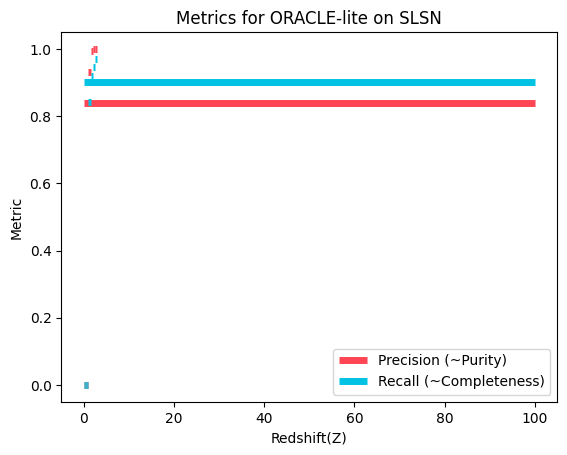

In [22]:
for (x_min, x_max), y in zip(z_range, precision):
    if x_max == z_range[-1][1]:
        plt.hlines(y, x_min, x_max, colors='#ff4554', lw=5, label='Precision (~Purity)')
    else:
        plt.hlines(y, x_min, x_max, colors='#ff4554', lw=5)

for (x_min, x_max), y in zip(z_range, recall):
    
    if x_max == z_range[-1][1]:
        plt.hlines(y, x_min, x_max, colors='#00c3e3', lw=5, label='Recall (~Completeness)')
    else:
        plt.hlines(y, x_min, x_max, colors='#00c3e3', lw=5)

plt.legend(loc='lower right')
plt.title('Metrics for ORACLE-lite on SLSN')

plt.xlabel("Redshift(Z)")
plt.ylabel("Metric")
plt.savefig('SLSN_ORACLE_lite.png')
plt.show()

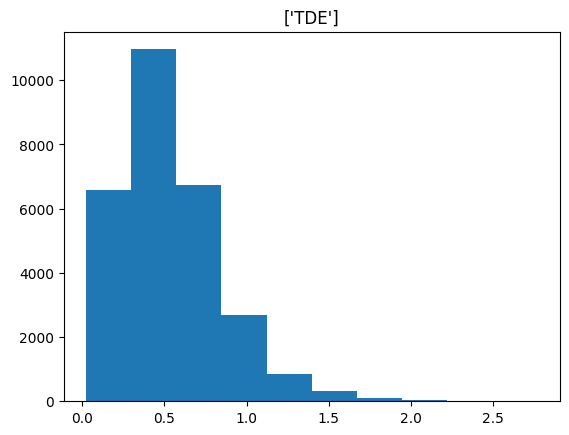

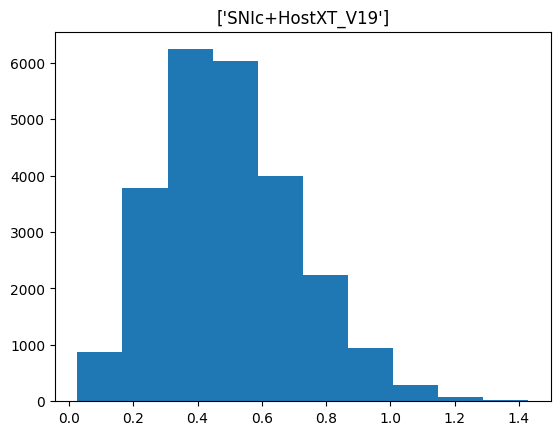

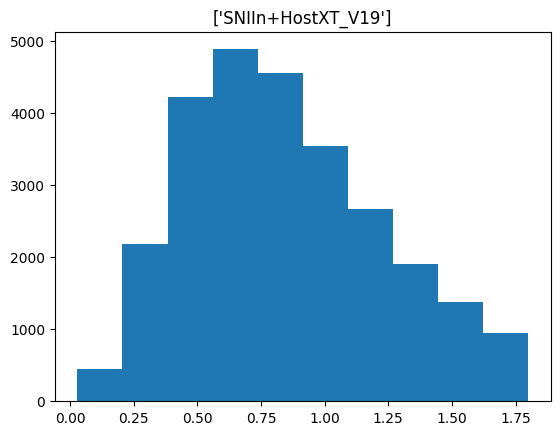

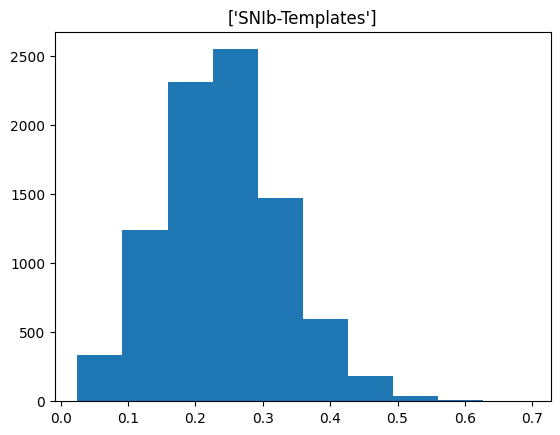

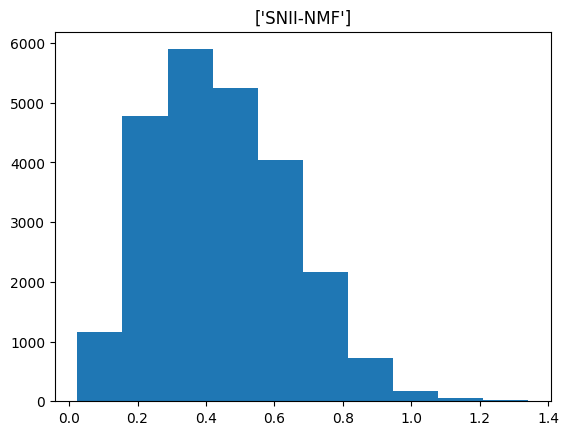

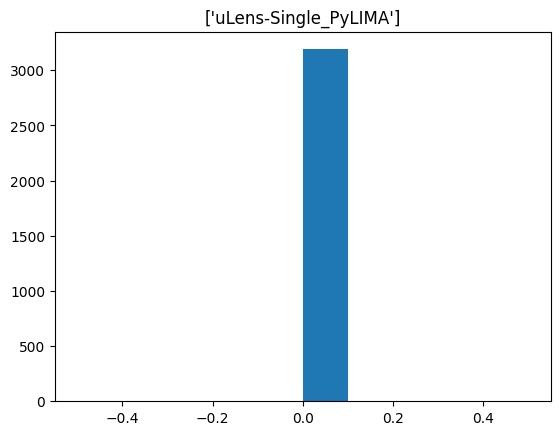

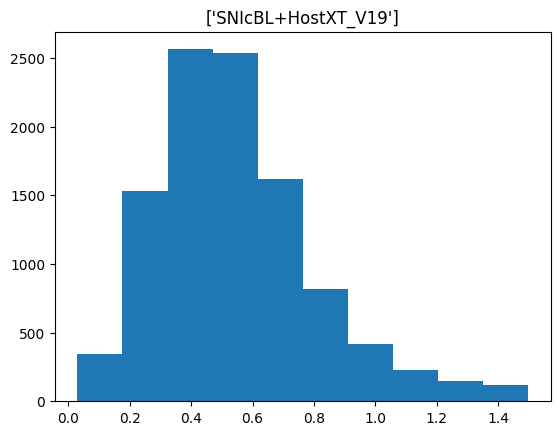

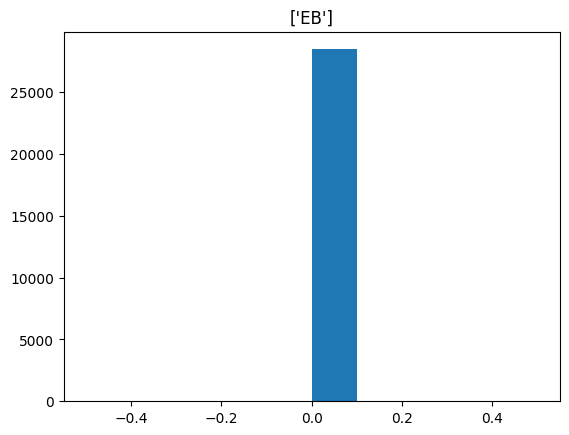

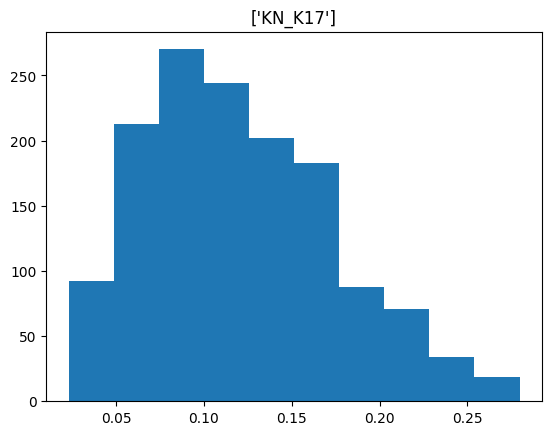

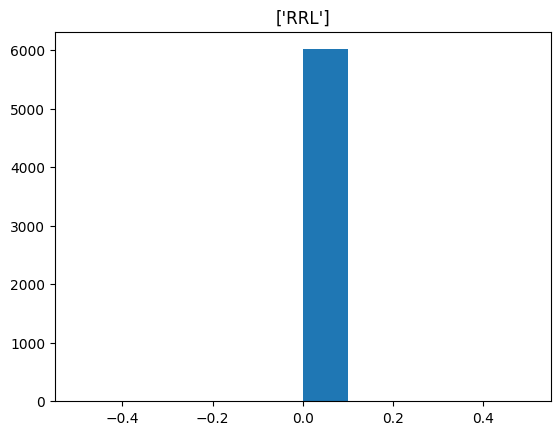

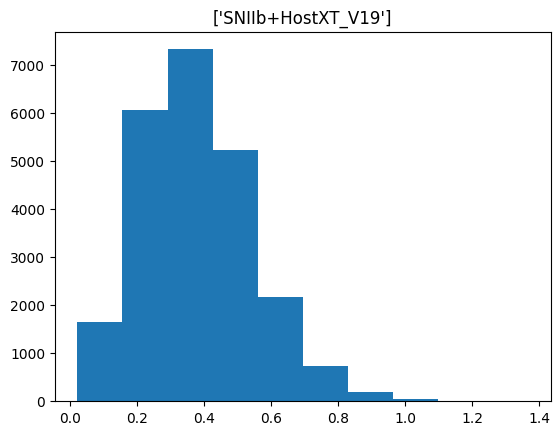

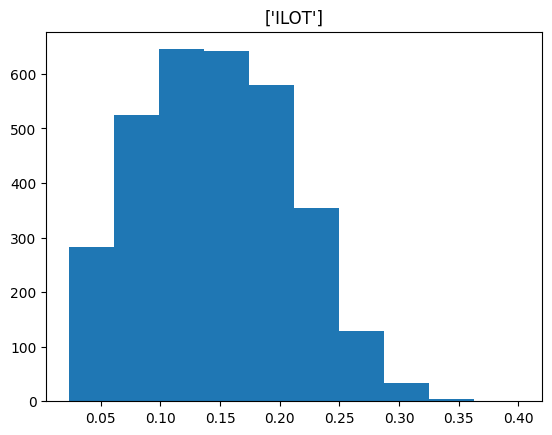

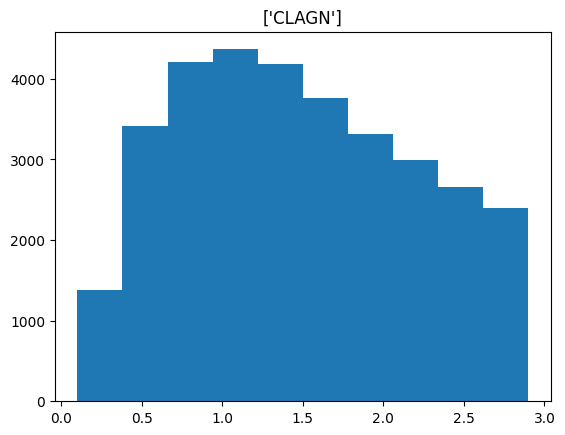

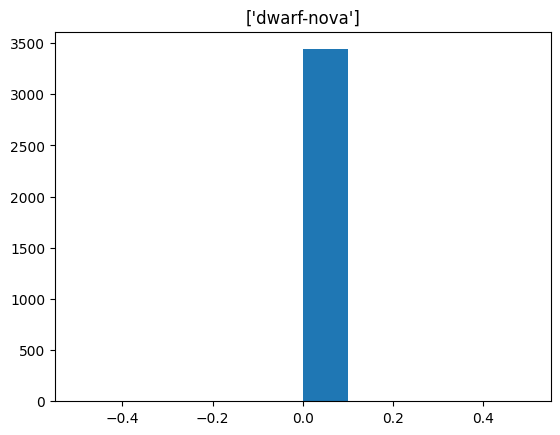

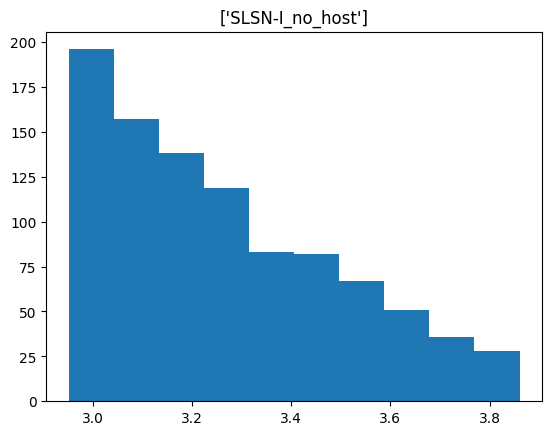

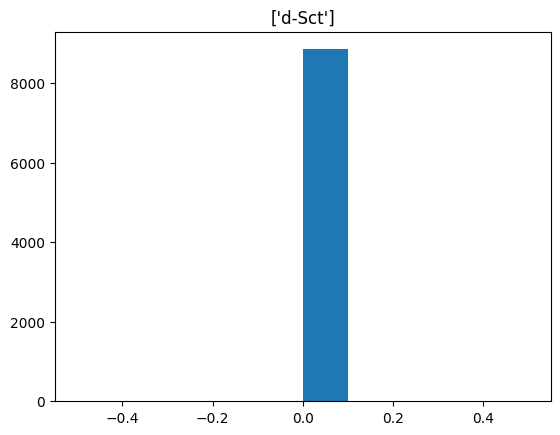

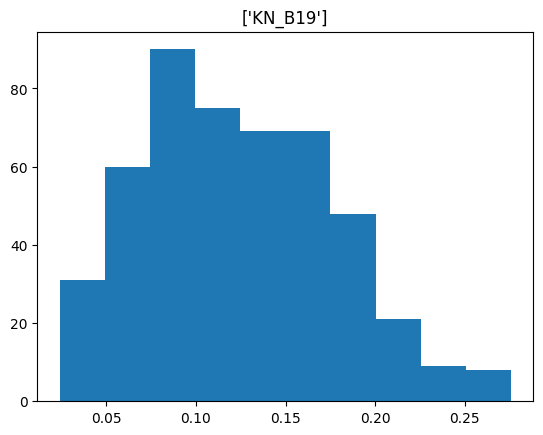

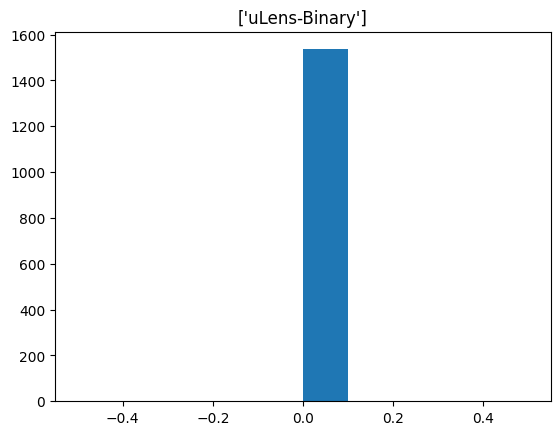

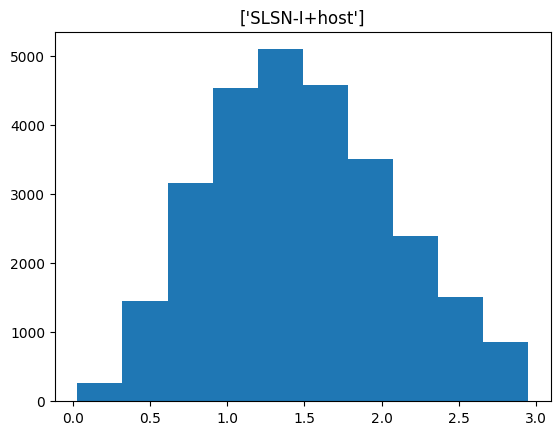

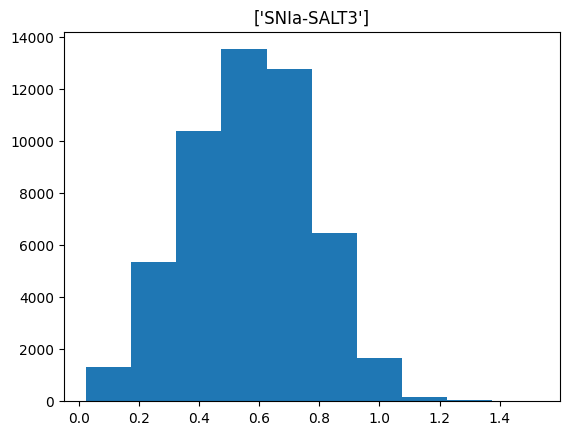

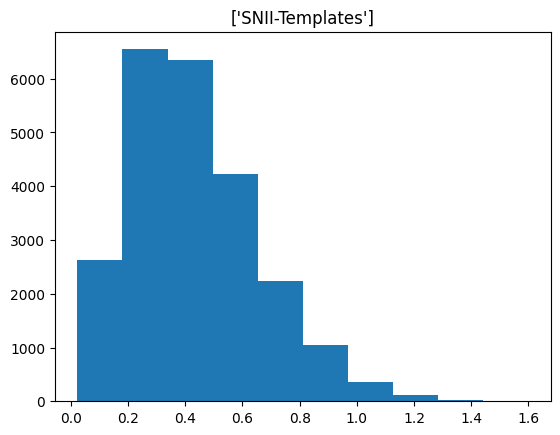

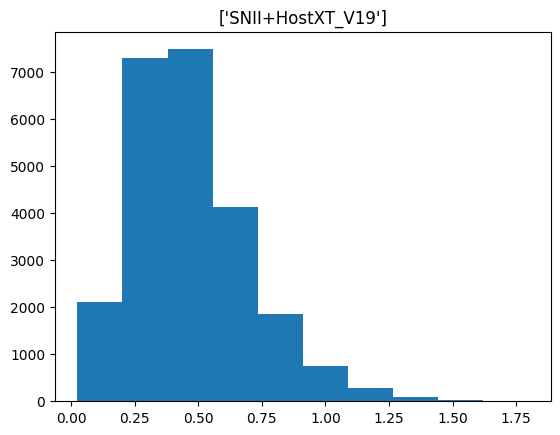

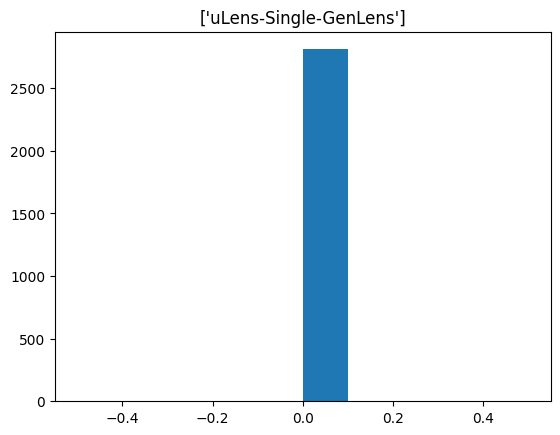

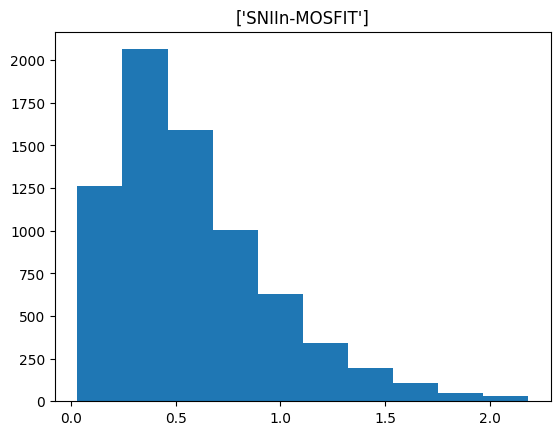

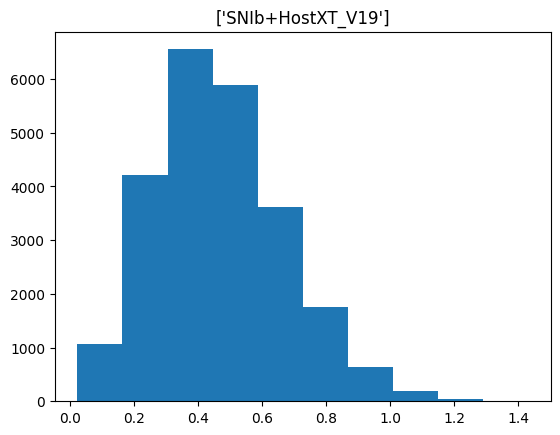

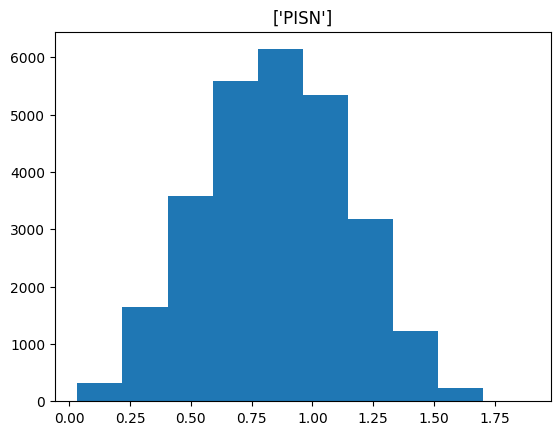

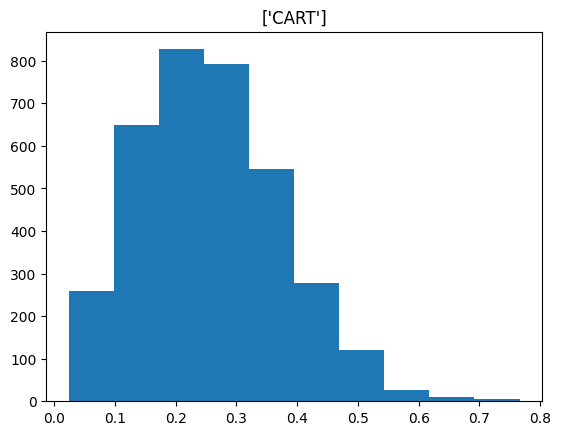

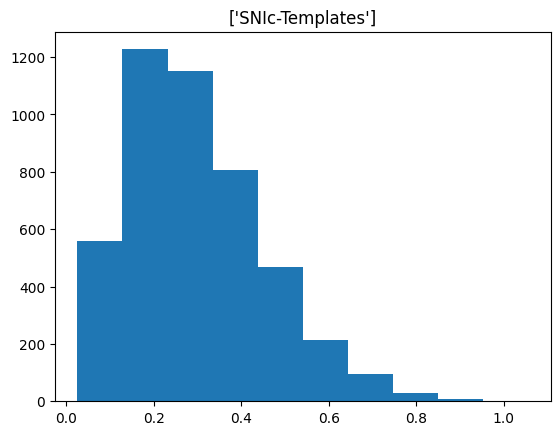

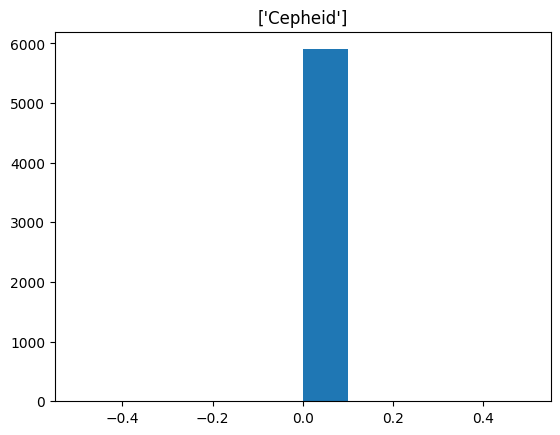

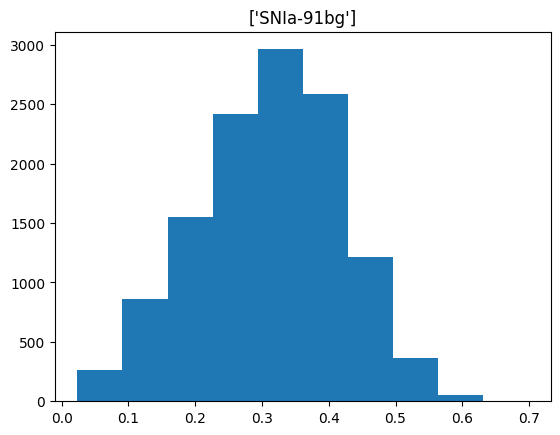

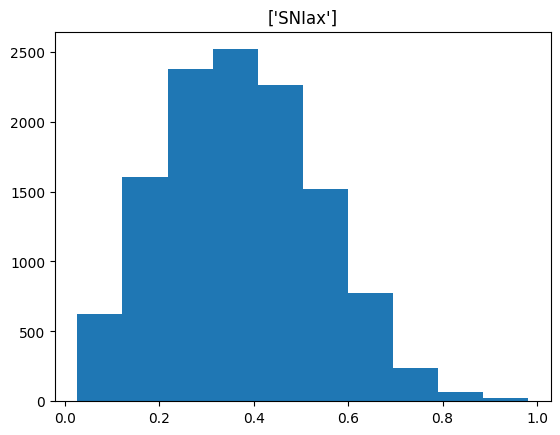

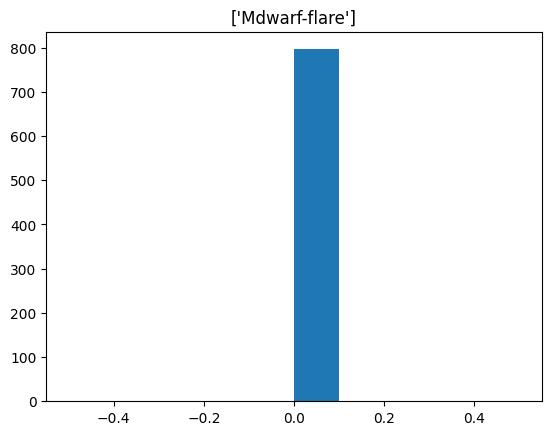

In [23]:
group_df = test_df[['SIM_REDSHIFT_CMB','ELASTICC_class']].group_by(['ELASTICC_class'])

for i in group_df:

    class_name = np.unique(i[1]['ELASTICC_class'])
    z = i[1]['SIM_REDSHIFT_CMB']

    plt.hist(z)
    plt.title(class_name)
    plt.show()

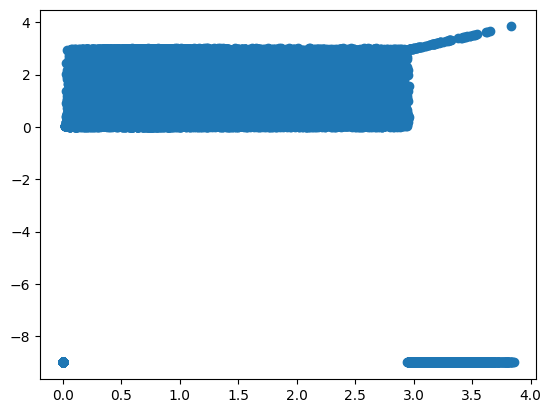

In [24]:
plt.scatter(test_df['SIM_REDSHIFT_HELIO'], test_df['REDSHIFT_HELIO'])

In [25]:
all_classification

SNID,true,pred,SIM_REDSHIFT_CMB,ELASTICC_class
i64,str,str,f64,str
46671463,"""CART""","""SNIax""",0.132733,"""CART"""
27578480,"""CART""","""CART""",0.176058,"""CART"""
6193724,"""CART""","""SNII""",0.187247,"""CART"""
4724156,"""CART""","""CART""",0.341509,"""CART"""
1148185,"""CART""","""SNIax""",0.334463,"""CART"""
…,…,…,…,…
16675826,"""uLens""","""uLens""",0.0,"""uLens-Single_PyLIMA"""
40526461,"""uLens""","""uLens""",0.0,"""uLens-Single_PyLIMA"""
72606986,"""uLens""","""uLens""",0.0,"""uLens-Single_PyLIMA"""


Text(0, 0.5, 'Density')

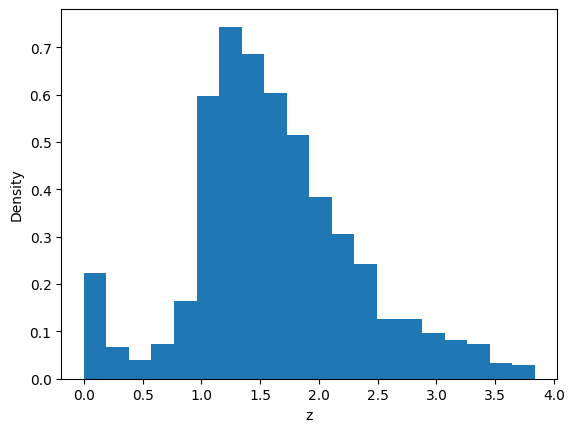

In [30]:
plt.hist(all_classification.filter((all_classification['pred']=='high-z-SLSN'))['SIM_REDSHIFT_CMB'], density=True, bins=20)
plt.xlabel('z')
plt.ylabel('Density')

In [27]:
len(all_classification.filter((all_classification['pred']=='high-z-SLSN') & (all_classification['SIM_REDSHIFT_CMB']>=1))) /len(all_classification.filter((all_classification['pred']=='high-z-SLSN')))

0.8648648648648649

<Axes: title={'center': 'Low z (z<1) objects missclassified as high-z-SLSN'}, xlabel='true'>

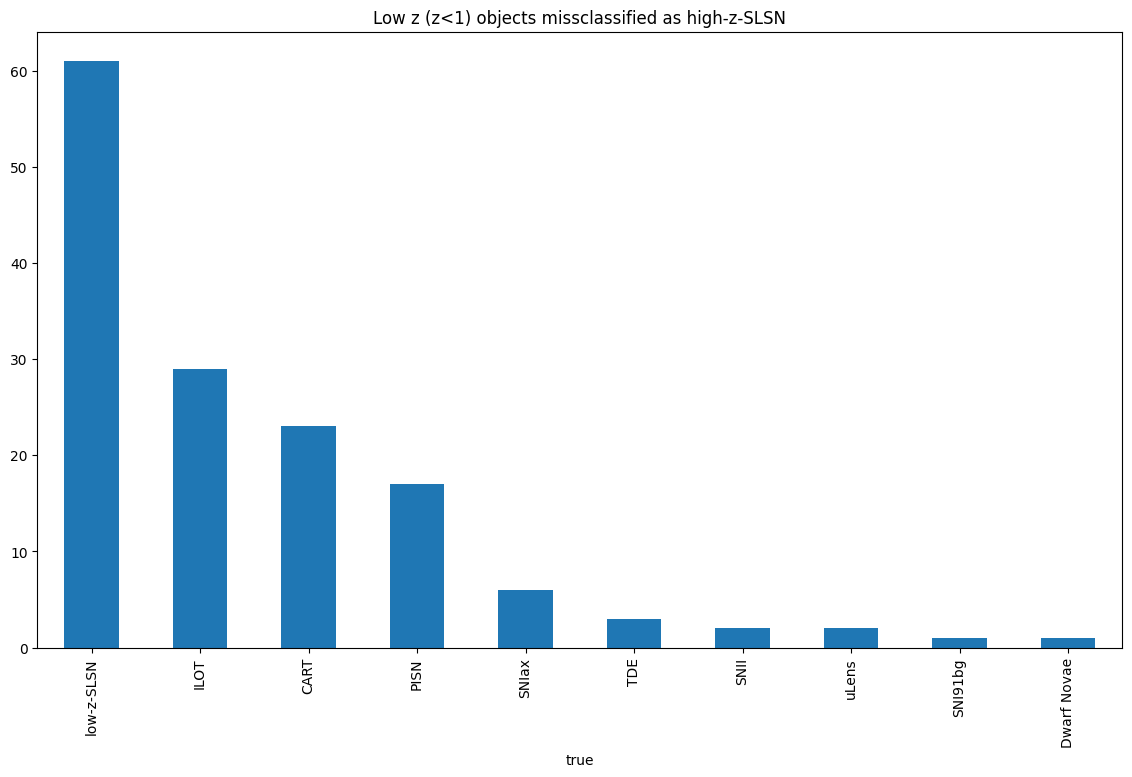

In [31]:
all_classification.filter((all_classification['pred']=='high-z-SLSN') & (all_classification['SIM_REDSHIFT_CMB']<1)).to_pandas()['true'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Low z (z<1) objects missclassified as high-z-SLSN")

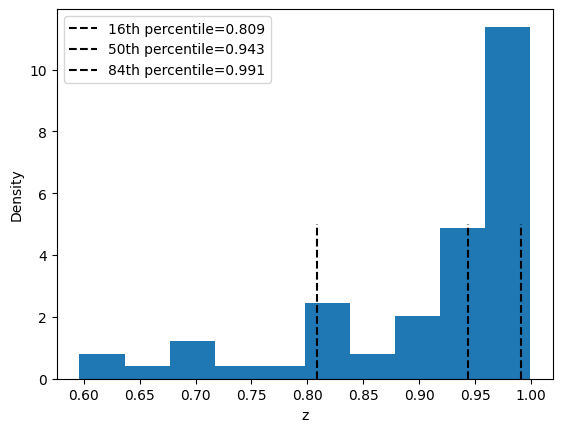

In [29]:
fp_lowzslsne_redshift = all_classification.filter((all_classification['pred']=='high-z-SLSN') & (all_classification['true']=='low-z-SLSN'))['SIM_REDSHIFT_CMB']
plt.hist(fp_lowzslsne_redshift, density=True)
plt.vlines(np.percentile(fp_lowzslsne_redshift, 16), 0, 5, color='black', linestyle='dashed', label=f"16th percentile={np.percentile(fp_lowzslsne_redshift, 16):.3f}")
plt.vlines(np.percentile(fp_lowzslsne_redshift, 50), 0, 5, color='black', linestyle='dashed', label=f"50th percentile={np.percentile(fp_lowzslsne_redshift, 50):.3f}")
plt.vlines(np.percentile(fp_lowzslsne_redshift, 84), 0, 5, color='black', linestyle='dashed', label=f"84th percentile={np.percentile(fp_lowzslsne_redshift, 84):.3f}")

plt.xlabel('z')
plt.ylabel('Density')

plt.legend()